## remark

1. small network -> less memory -> lagger batchsize -> less tranning time
2. shortter init stage -> longger finetune stage
3. use data argument in finetune stage

## import

In [70]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense, SpatialDropout2D
from keras.layers.core import Lambda, Reshape, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, Dot, Multiply, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import keras
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger


from keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.regularizers import l2
from keras.losses import binary_crossentropy


import keras.backend.tensorflow_backend as KTF
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   
session = tf.Session(config=config)
KTF.set_session(session)

print(keras.__version__)
print(tf.__version__)

2.2.4
1.10.0


In [2]:
%matplotlib inline

import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

# from https://github.com/neptune-ml/open-solution-salt-identification
from common_blocks.augmentation import iaa, PadFixed, RandomCropFixedSize
from common_blocks.utils import plot_list

import gc

## data

D:\Anaconda2\envs\py3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


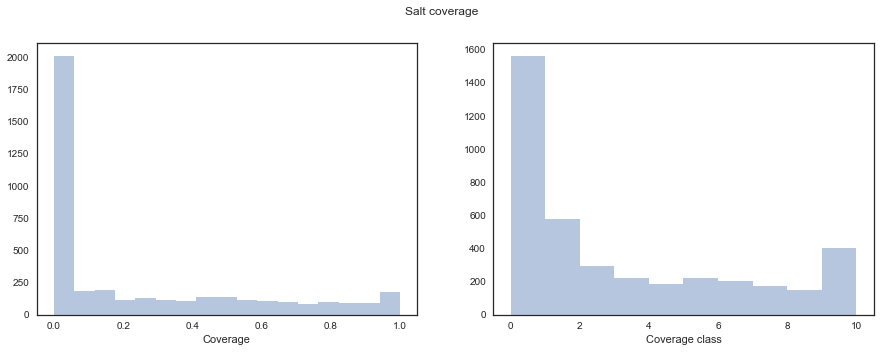

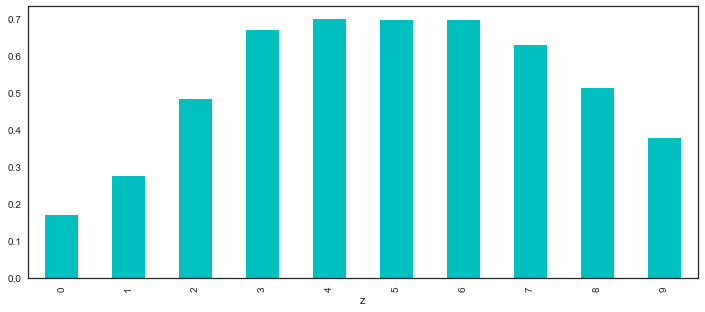

In [3]:
# Set some parameters
exp_code = "034"
img_size_ori = 101
img_size_target = 101
im_width = 128
im_height = 128
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf], labels=range(10))
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

In [4]:
train_df.head()

,z,images,masks,coverage,coverage_class,c1,z_cut,c_cut
id,,,,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,0,8,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6,1,7,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10,1,4,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2,1,7,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1,1,7,1


In [4]:
z_cutoff = [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf]
c_cutoff = [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf]

z_cutoff = [-np.Inf, 250, 500, 750, np.Inf]
c_cutoff = [-np.Inf, 0.0, .2, .4, .6, .8, np.Inf]

z_cut = pd.cut(train_df.z, z_cutoff, labels=range(len(z_cutoff) - 1))
c_cut = pd.cut(train_df.coverage, c_cutoff, labels=range(len(c_cutoff) - 1))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut
train_df["cz_cut"] = (c_cut.astype("int") + 1) * 100 + z_cut.astype("int")

In [6]:
train_df.cz_cut.value_counts()

102    482
101    461
100    370
202    366
201    320
103    249
402    201
302    190
602    175
401    157
601    155
301    146
502    134
501    134
203    107
200     79
603     57
303     45
403     43
503     38
400     29
300     29
600     17
500     16
Name: cz_cut, dtype: int64

## 5fold-split --seed 67373

In [5]:
from sklearn.model_selection import StratifiedKFold

def adjust_split(pair, x_size=3200):
    x, y = pair
    offset = len(x) - x_size
    print(offset)
    if offset > 0:
        y_new = np.append(y, x[:offset])
        x_new = x[offset:].copy()
    elif offset < 0:
        y_new = y[:offset].copy()
        x_new = np.append(x, y[offset:])
    else:
        x_new, y_new = x, y
    return x_new, y_new

X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.cz_cut.values.copy()

skf = StratifiedKFold(n_splits=5, random_state=67373)
skf.get_n_splits(X, y)
kfold_index = [adjust_split(ob) for ob in skf.split(X, y)]

y.shape

for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

-9
-4
1
3
9
(3200,) (800,)
(3200,) (800,)
(3200,) (800,)
(3200,) (800,)
(3200,) (800,)


##  loss & metric

copy bce_dice_loss & focal_loss from https://www.kaggle.com/alexanderliao/u-net-bn-aug-strat-focal-loss-fixed

### bce

In [6]:
def my_bce(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred))

### bce dice loss

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred)) + dice_loss(y_true, K.sigmoid(y_pred))

### focal loss

In [8]:
def focal_loss(y_true, y_pred):
    gamma=0.75
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    pt_1 = K.clip(pt_1, 1e-3, .999)
    pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

### lovasz loss -- with elu

In [9]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None, use_relu=True):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab, use_relu=use_relu)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore), use_relu=use_relu)
    return loss


def lovasz_hinge_flat(logits, labels, use_relu=True):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        # if use_relu:
        #     loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        #     # loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void") ## !!
        # else:
        #     loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void") ## !!
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None, use_relu=True)
    return loss


def lovasz_loss_elu(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None, use_relu=False)
    return loss

### bce_lovasz_loss

In [44]:
def bce_lovasz_loss(y_true, y_pred):
    return binary_crossentropy(y_true, K.sigmoid(y_pred)) + 0.1 * lovasz_loss_elu(y_true, y_pred)

### my iou metric

In [11]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > .45], tf.float64)

## model structure --resnext & scse

download blocks code from 

1. ResNet https://github.com/qubvel/classification_models
2. Unet https://github.com/qubvel/segmentation_models

### resnext block

In [12]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params


def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def GroupConv2D(filters, kernel_size, conv_params, conv_name, strides=(1, 1), cardinality=8):

    def layer(input_tensor):
        print(conv_name, "-i-", input_tensor.shape)
        grouped_channels = int(input_tensor.shape[-1]) // cardinality
        blocks = []
        for c in range(cardinality):
            x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels])(input_tensor)
            name = conv_name + '_' + str(c)
            x = Conv2D(grouped_channels, kernel_size, strides=strides,
                       name=name, **conv_params)(x)
            blocks.append(x)

        x = Concatenate(axis=-1)(blocks)
        print(conv_name, "-o-", x.shape)
        return x
    return layer


def conv_block(filters, stage, block, strides=(2, 2)):
    """The conv block is the block that has conv layer at shortcut.
    # Arguments
        filters: integer, used for first and second conv layers, third conv layer double this value
        strides: tuple of integers, strides for conv (3x3) layer in block
        stage: integer, current stage label, used for generating layer names
        block: integer, current block label, used for generating layer names
    # Returns
        Output layer for the block.
    """

    def layer(input_tensor):

        # extracting params and names for layers
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '0', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '0')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '1', **bn_params)(x)
        x = Activation('relu', name=relu_name + '1')(x)

        x = ZeroPadding2D(padding=(1, 1))(x)
        x = GroupConv2D(filters, (3, 3), conv_params, conv_name + '2', strides=strides)(x)
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)

        x = Conv2D(filters * 2, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)

        shortcut = Conv2D(filters * 2, (1, 1), name=sc_name, strides=strides, **conv_params)(input_tensor)
        shortcut = BatchNormalization(name=sc_name +'_bn', **bn_params)(shortcut)
        x = Add()([x, shortcut])

        return x

    return layer


def identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        filters: integer, used for first and second conv layers, third conv layer double this value
        stage: integer, current stage label, used for generating layer names
        block: integer, current block label, used for generating layer names
    # Returns
        Output layer for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '0', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '0')(x)
        x = Conv2D(filters // 2, (1, 1), name=conv_name + '1', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '1', **bn_params)(x)
        x = Activation('relu', name=relu_name + '1')(x)

        x = ZeroPadding2D(padding=(1, 1))(x)
        x = GroupConv2D(filters // 2, (3, 3), conv_params, conv_name + '2')(x)
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)

        # x = Conv2D(filters * 2, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Add()([x, input_tensor])

        return x

    return layer


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer

### scse block

In [13]:
def Scse(re=16):
    def layer(input_tensor):
        channel_cnt = int(input_tensor.shape[-1])

        x = GlobalMaxPooling2D(data_format="channels_last")(input_tensor)
        x = Dense(int(channel_cnt // re))(x)
        x = Activation("relu")(x)
        x = Dense(channel_cnt)(x)
        x = Activation("sigmoid")(x)
        x = Reshape((1, 1, channel_cnt))(x)
        x = Multiply()([input_tensor, x])

        y = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal")(input_tensor)
        y = Activation("sigmoid")(y)
        y = Multiply()([input_tensor, y])

        z = Add()([x, y])
        return z

    return layer


def scse_block(re, stage, block):
    def layer(input_tensor):
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)
        x = BatchNormalization(name="scse_" + bn_name, **bn_params)(input_tensor)
        x = Activation('relu', name="scse_" + relu_name)(x)
        x = Scse(re)(x)
        return x
    return layer


def identity_scse_block(filters, stage, block, re=8):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        filters: integer, used for first and second conv layers, third conv layer double this value
        stage: integer, current stage label, used for generating layer names
        block: integer, current block label, used for generating layer names
    # Returns
        Output layer for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '0', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name)(x)
        x = Conv2D(filters // 2, (1, 1), name=conv_name + '1', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '1', **bn_params)(x)
        x = Activation('relu', name=relu_name + '1')(x)

        x = ZeroPadding2D(padding=(1, 1))(x)
        x = GroupConv2D(filters // 2, (3, 3), conv_params, conv_name + '2')(x)
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)

        x = Conv2D(filters, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Scse(re)(x)

        x = Add()([x, input_tensor])

        return x

    return layer

def conv_scse_block(filters, stage, block, re=8):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        filters: integer, used for first and second conv layers, third conv layer double this value
        stage: integer, current stage label, used for generating layer names
        block: integer, current block label, used for generating layer names
    # Returns
        Output layer for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '0', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name)(x)
        x = Conv2D(filters // 2, (1, 1), name=conv_name + '1', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '1', **bn_params)(x)
        x = Activation('relu', name=relu_name + '1')(x)

        x = ZeroPadding2D(padding=(1, 1))(x)
        x = GroupConv2D(filters // 2, (3, 3), conv_params, conv_name + '2')(x)
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)

        # x = Conv2D(filters * 2, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Scse(re)(x)
        x = BatchNormalization(name=bn_name + '4', **bn_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(input_tensor)
        shortcut = BatchNormalization(name=sc_name +'_bn', **bn_params)(shortcut)
        x = Add()([x, shortcut])

        return x

    return layer

def basic_identity_scse_block(filters, stage, block, re=8):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Scse(re)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2), re=8):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Scse(re)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer

### unet256 + resnext

In [14]:
ACTIVATION = "relu"


def _build_unet256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 256 -> 128
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = scse_block(start_neurons * 1, 11, 1)(conv1)

    # 128 -> 64
    conv2 = conv_block(start_neurons * 1, 11, 2)(conv1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = scse_block(start_neurons * 2, 12, 1)(conv2)

    # 64 -> 32
    conv3 = conv_block(start_neurons * 2, 12, 2)(conv2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = scse_block(start_neurons * 4, 13, 1)(conv3)

    # 32 -> 16
    conv4 = conv_block(start_neurons * 4, 13, 2)(conv3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = scse_block(start_neurons * 8, 14, 1)(conv4)

    # Middle
    convm = conv_block(start_neurons * 8, 14, 2)(conv4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = scse_block(start_neurons * 16, 21, 1)(convm)

    # 16 -> 32
    deconv4 = UpSampling2D()(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Activation(ACTIVATION)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = scse_block(start_neurons * 8, 34, 1)(uconv4)
    # uconv4 = scse_block(start_neurons * 8, 34, 2)(uconv4)

    # 32 -> 64
    deconv3 = UpSampling2D()(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Activation(ACTIVATION)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = scse_block(start_neurons * 4, 33, 1)(uconv3)
    # uconv3 = scse_block(start_neurons * 4, 33, 2)(uconv3)

    # 64 -> 128
    deconv2 = UpSampling2D()(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Activation(ACTIVATION)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = scse_block(start_neurons * 2, 32, 1)(uconv2)
    # uconv2 = scse_block(start_neurons * 2, 32, 2)(uconv2)

    # 128 -> 256
    deconv1 = UpSampling2D()(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = scse_block(start_neurons * 1, 31, 1)(uconv1)
    # uconv1 = scse_block(start_neurons * 1, 31, 2)(uconv1)

    # magic layer
    output_layer = Concatenate()([
        uconv1,
        UpSampling2D()(uconv2),
        UpSampling2D(size=(4, 4))(uconv3),
        UpSampling2D(size=(8, 8))(uconv4)
    ])
    
    # output layer
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio // 2)(output_layer)    # not run
    output_layer = Dropout(DropoutRatio)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="output_conv2")(output_layer)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet256ref + resnext

In [15]:
ACTIVATION = "relu"


def _build_unet256_ref(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 256 -> 128
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    # conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 128 -> 64
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    # conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # pool2 = Dropout(DropoutRatio / 2)(pool2)

    # 64 -> 32
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    # conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # pool3 = Dropout(DropoutRatio / 2)(pool3)

    # 32 -> 16
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    # conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio / 2)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 16 -> 32
    deconv4 = UpSampling2D()(convm)
    uconv4 = concatenate([deconv4, conv4])

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    # uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    # uconv4 = scse_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 32 -> 64
    deconv3 = UpSampling2D()(uconv4)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    # uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    # uconv3 = scse_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 64 -> 128
    deconv2 = UpSampling2D()(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    # uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    # uconv2 = scse_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 128 -> 256
    deconv1 = UpSampling2D()(uconv2)
    uconv1 = concatenate([deconv1, conv1])

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    # uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    # uconv1 = scse_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    # magic layer
    '''
    output_layer = Concatenate()([
        uconv1,
        UpSampling2D()(uconv2),
        UpSampling2D(size=(4, 4))(uconv3),
        UpSampling2D(size=(8, 8))(uconv4)
    ])
    '''

    # output layer

    # output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    # output_layer = BatchNormalization(name="output_bn")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio // 2)(output_layer)    # not run
    output_layer = Dropout(DropoutRatio)(uconv1)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (3, 3), padding="same", name="output_conv2")(output_layer)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34 + resnet

In [16]:
ACTIVATION = "relu"


def _build_unet34(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 3)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 3)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 4)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 3)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 4)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 3)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34 for 128 & 256 + resnet

In [17]:
ACTIVATION = "relu"


def _build_unet34_for256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 3)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 3)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 4)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 3)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 4)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 3)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34magic for 128 & 256 + resnet

In [18]:
def _build_unet34magic_for256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D()(uconv2),
        UpSampling2D(size=(4, 4))(uconv3),
        UpSampling2D(size=(8, 8))(uconv4)
    ])
    
    # output layer
    output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34magicfixed for 128

In [19]:
def _build_unet34magicfixed_for256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2),
        UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3),
        UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4)
    ])
    
    # output layer
    output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34basicmagic for 128

In [20]:
def _build_unet34magicbasic_for256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = basic_identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = basic_identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = basic_identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = basic_identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = basic_identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = basic_identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = basic_identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = basic_identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = basic_identity_block(start_neurons * 16, 21, 0)(convm)
    convm = basic_identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2),
        UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3),
        UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4)
    ])
    
    # output layer
    output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34basicmagic for 128 mix drop

In [ ]:
def _build_unet34magicbasic_for256_mixdrop(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = basic_identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = basic_identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = SpatialDropout2D(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = basic_identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = basic_identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = SpatialDropout2D(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = basic_identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = basic_identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = SpatialDropout2D(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = basic_identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = basic_identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = SpatialDropout2D(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = basic_identity_block(start_neurons * 16, 21, 0)(convm)
    convm = basic_identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    output_layer = Concatenate()([
        SpatialDropout2D(DropoutRatio / 2)(uconv1),
        SpatialDropout2D(DropoutRatio)(UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2)),
        SpatialDropout2D(DropoutRatio)(UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3)),
        SpatialDropout2D(DropoutRatio)(UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4))
    ])
    
    # output layer
    # output_layer = SpatialDropout2D(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34basicscse-magic for 128

In [21]:
REDUCTION = 4

def _build_unet34magicscse_for256(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = basic_identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = basic_identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = scse_block(REDUCTION, 11, 2)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = basic_identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = basic_identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = scse_block(REDUCTION * 2, 12, 2)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = basic_identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = basic_identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = scse_block(REDUCTION * 4, 13, 2)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = basic_identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = basic_identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = scse_block(REDUCTION * 8, 14, 2)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = basic_identity_block(start_neurons * 16, 21, 0)(convm)
    convm = basic_identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = scse_block(REDUCTION * 8, 34, 2)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = scse_block(REDUCTION * 4, 33, 2)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = scse_block(REDUCTION * 2, 32, 2)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = scse_block(REDUCTION, 31, 2)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2),
        UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3),
        UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4)
    ])
    
    # output layer
    output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34basicscse-magic for 128 mix drop

In [90]:
REDUCTION = 4

def _build_unet34magicscse_for256_mixdrop(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = basic_identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = basic_identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    # conv1 = scse_block(REDUCTION, 11, 2)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = basic_identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = basic_identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    # conv2 = scse_block(REDUCTION * 2, 12, 2)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = basic_identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = basic_identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    # conv3 = scse_block(REDUCTION * 4, 13, 2)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = basic_identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = basic_identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    # conv4 = scse_block(REDUCTION * 8, 14, 2)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = basic_identity_block(start_neurons * 16, 21, 0)(convm)
    convm = basic_identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = scse_block(REDUCTION * 8, 34, 2)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = scse_block(REDUCTION * 4, 33, 2)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = scse_block(REDUCTION * 2, 32, 2)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = scse_block(REDUCTION, 31, 2)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2),
        UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3),
        UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4)
    ])
    
    # output layer
    # output_layer = SpatialDropout2D(DropoutRatio)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = SpatialDropout2D(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34basicscse-magic-dropmore for 128 & 256 + resnet

In [23]:
REDUCTION = 4

def _build_unet34magicscse_for256_dropmore(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = basic_identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = basic_identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Dropout(DropoutRatio / 2)(conv1)
    conv1 = scse_block(REDUCTION, 11, 2)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = basic_identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = basic_identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Dropout(DropoutRatio / 2)(conv2)
    conv2 = scse_block(REDUCTION * 2, 12, 2)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = basic_identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = basic_identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Dropout(DropoutRatio / 2)(conv3)
    conv3 = scse_block(REDUCTION * 4, 13, 2)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = basic_identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = basic_identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Dropout(DropoutRatio / 2)(conv4)
    conv4 = scse_block(REDUCTION * 8, 14, 2)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = basic_identity_block(start_neurons * 16, 21, 0)(convm)
    convm = basic_identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = basic_identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Dropout(DropoutRatio / 2)(uconv4)
    uconv4 = scse_block(REDUCTION * 8, 34, 2)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = basic_identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Dropout(DropoutRatio / 2)(uconv3)
    uconv3 = scse_block(REDUCTION * 4, 33, 2)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = basic_identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Dropout(DropoutRatio / 2)(uconv2)
    uconv2 = scse_block(REDUCTION * 2, 32, 2)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = basic_identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    uconv1 = scse_block(REDUCTION, 31, 2)(uconv1)

    output_layer = Concatenate()([
        uconv1,
        UpSampling2D(size=(2, 2), interpolation="bilinear")(uconv2),
        UpSampling2D(size=(4, 4), interpolation="bilinear")(uconv3),
        UpSampling2D(size=(8, 8), interpolation="bilinear")(uconv4)
    ])
    
    # output layer
    output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = BatchNormalization(name="output_bn0")(output_layer)
    # output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(start_neurons * 4, (3, 3), padding="same", name="output_conv1")(output_layer)
    output_layer = BatchNormalization(name="output_bn1")(output_layer) # not run
    # output_layer = Dropout(DropoutRatio / 2)(output_layer)
    output_layer = Activation(ACTIVATION)(output_layer)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### thinunet + resnext

In [24]:
ACTIVATION = "relu"


def _build_thinunet(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### link-net + resnext

In [25]:
def _build_linknet(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = Add()([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = Add()([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = Add()([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = Add()([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    # uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet + resnext + scse block

In [26]:
def _build_unet_scse(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = scse_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = scse_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = scse_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = scse_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = scse_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = scse_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = scse_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = scse_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### thinunent + resnext + scse-block

In [27]:
def _build_unet_scse(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = scse_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = scse_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = scse_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = scse_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = scse_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = scse_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = scse_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = scse_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### link-net + resnext + scse-block

In [28]:
def _build_linknet_scse(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = scse_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = scse_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = scse_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = scse_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = Add()([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = scse_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = Add()([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = scse_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = Add()([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = scse_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = Add()([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = scse_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    # uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

### unet34 + resnext + scse-block

In [29]:
ACTIVATION = "relu"

def _build_unet34_scse(input_layer, start_neurons, DropoutRatio=0.5, use_sigmoid=False):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="en1_a_conv")(input_layer)
    conv1 = identity_block(start_neurons * 1, 11, 0)(conv1)
    conv1 = identity_block(start_neurons * 1, 11, 1)(conv1)
    conv1 = scse_block(start_neurons * 1, 11, 2)(conv1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="en2_a_conv")(pool1)
    conv2 = identity_block(start_neurons * 2, 12, 0)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 1)(conv2)
    conv2 = identity_block(start_neurons * 2, 12, 2)(conv2)
    conv2 = scse_block(start_neurons * 2, 12, 3)(conv2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="en3_a_conv")(pool2)
    conv3 = identity_block(start_neurons * 4, 13, 0)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 1)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 2)(conv3)
    conv3 = identity_block(start_neurons * 4, 13, 3)(conv3)
    conv3 = scse_block(start_neurons * 4, 13, 4)(conv3)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="en4_a_conv")(pool3)
    conv4 = identity_block(start_neurons * 8, 14, 0)(conv4)
    conv4 = identity_block(start_neurons * 8, 14, 1)(conv4)
    conv4 = scse_block(start_neurons * 8, 14, 2)(conv4)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same", name="vm_a_conv")(pool4)
    convm = identity_block(start_neurons * 16, 21, 0)(convm)
    convm = identity_block(start_neurons * 16, 21, 1)(convm)
    convm = Activation(ACTIVATION)(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)

    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same", name="de4_a_conv")(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 0)(uconv4)
    uconv4 = identity_block(start_neurons * 8, 34, 1)(uconv4)
    uconv4 = scse_block(start_neurons * 8, 34, 2)(uconv4)
    uconv4 = Activation(ACTIVATION)(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same", name="de3_a_conv")(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 0)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 1)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 2)(uconv3)
    uconv3 = identity_block(start_neurons * 4, 33, 3)(uconv3)
    uconv3 = scse_block(start_neurons * 4, 33, 4)(uconv3)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same", name="de2_a_conv")(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 0)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 1)(uconv2)
    uconv2 = identity_block(start_neurons * 2, 32, 2)(uconv2)
    uconv2 = scse_block(start_neurons * 2, 32, 3)(uconv2)
    uconv2 = Activation(ACTIVATION)(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)

    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same", name="de1_a_conv")(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 0)(uconv1)
    uconv1 = identity_block(start_neurons * 1, 31, 1)(uconv1)
    uconv1 = scse_block(start_neurons * 1, 31, 2)(uconv1)
    uconv1 = Activation(ACTIVATION)(uconv1)

    uconv1 = Dropout(DropoutRatio / 2)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", name="final_conv")(uconv1)

    if use_sigmoid:
        output_layer = Activation("sigmoid")(output_layer)

    return output_layer

## model builders

In [30]:
def build_model(img_size_target, builder=_build_unet34):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = builder(input_layer, 16, 0.5, use_sigmoid=True)

    model = Model(input_layer, output_layer)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric_2])
    return model

In [31]:
def build_stage0_model(img_size_target, builder=_build_unet34, loss=focal_loss, metric=my_iou_metric_2, opt="adam", use_sigmoid=True):
    print("local: model builders")
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = builder(input_layer, 16, 0.5, use_sigmoid=use_sigmoid)
    model = Model(input_layer, output_layer)

    model.compile(loss=loss, optimizer=opt, metrics=[metric])
    return model

In [32]:
def get_model_params(loss_name):
    stack = {
        "bce": {"loss": my_bce, "use_sigmoid": False, "metric": my_iou_metric},
        "bcedice": {"loss": bce_dice_loss, "use_sigmoid": False, "metric": my_iou_metric},
        "bcelovasz": {"loss": bce_lovasz_loss, "use_sigmoid": False, "metric": my_iou_metric},
        "focal": {"loss": focal_loss, "use_sigmoid": True, "metric": my_iou_metric_2},
        "lovasz": {"loss": lovasz_loss, "use_sigmoid": False, "metric": my_iou_metric}
    }
    
    metric_names = {
        "bce": "my_iou_metric",
        "bcedice": "my_iou_metric",
        "bcelovasz": "my_iou_metric",
        "focal": "my_iou_metric_2",
        "lovasz": "my_iou_metric"
    }

    return stack.get(loss_name), metric_names.get(loss_name)

In [33]:
get_model_params("lovasz")

({'loss': <function __main__.lovasz_loss(y_true, y_pred)>,
  'use_sigmoid': False,
  'metric': <function __main__.my_iou_metric(label, pred)>},
 'my_iou_metric')

In [34]:
model = build_stage0_model(256, _build_unet256, bce_dice_loss, metric=my_iou_metric, opt="adam", use_sigmoid=False)

local: model builders
stage12_unit1_conv2 -i- (?, 258, 258, 8)
stage12_unit1_conv2 -o- (?, 256, 256, 8)
stage12_unit2_conv2 -i- (?, 258, 258, 8)
stage12_unit2_conv2 -o- (?, 256, 256, 8)
stage12_unit3_conv2 -i- (?, 258, 258, 16)
stage12_unit3_conv2 -o- (?, 128, 128, 16)
stage13_unit1_conv2 -i- (?, 130, 130, 16)
stage13_unit1_conv2 -o- (?, 128, 128, 16)
stage13_unit2_conv2 -i- (?, 130, 130, 16)
stage13_unit2_conv2 -o- (?, 128, 128, 16)
stage13_unit3_conv2 -i- (?, 130, 130, 32)
stage13_unit3_conv2 -o- (?, 64, 64, 32)
stage14_unit1_conv2 -i- (?, 66, 66, 32)
stage14_unit1_conv2 -o- (?, 64, 64, 32)
stage14_unit2_conv2 -i- (?, 66, 66, 32)
stage14_unit2_conv2 -o- (?, 64, 64, 32)
stage14_unit3_conv2 -i- (?, 66, 66, 64)
stage14_unit3_conv2 -o- (?, 32, 32, 64)
stage15_unit1_conv2 -i- (?, 34, 34, 64)
stage15_unit1_conv2 -o- (?, 32, 32, 64)
stage15_unit2_conv2 -i- (?, 34, 34, 64)
stage15_unit2_conv2 -o- (?, 32, 32, 64)
stage15_unit3_conv2 -i- (?, 34, 34, 128)
stage15_unit3_conv2 -o- (?, 16, 16, 128

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
en1_a_conv (Conv2D)             (None, 256, 256, 16) 304         input[0][0]                      
__________________________________________________________________________________________________
stage12_unit1_bn0 (BatchNormali (None, 256, 256, 16) 64          en1_a_conv[0][0]                 
__________________________________________________________________________________________________
stage12_unit1_relu0 (Activation (None, 256, 256, 16) 0           stage12_unit1_bn0[0][0]          
__________________________________________________________________________________________________
stage12_un

stage12_unit3_conv1 (Conv2D)    (None, 256, 256, 16) 256         stage12_unit3_relu0[0][0]        
__________________________________________________________________________________________________
stage12_unit3_bn1 (BatchNormali (None, 256, 256, 16) 64          stage12_unit3_conv1[0][0]        
__________________________________________________________________________________________________
stage12_unit3_relu1 (Activation (None, 256, 256, 16) 0           stage12_unit3_bn1[0][0]          
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 258, 258, 16) 0           stage12_unit3_relu1[0][0]        
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 258, 258, 2)  0           zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
lambda_18 

stage13_unit2_conv2_4 (Conv2D)  (None, 128, 128, 2)  36          lambda_37[0][0]                  
__________________________________________________________________________________________________
stage13_unit2_conv2_5 (Conv2D)  (None, 128, 128, 2)  36          lambda_38[0][0]                  
__________________________________________________________________________________________________
stage13_unit2_conv2_6 (Conv2D)  (None, 128, 128, 2)  36          lambda_39[0][0]                  
__________________________________________________________________________________________________
stage13_unit2_conv2_7 (Conv2D)  (None, 128, 128, 2)  36          lambda_40[0][0]                  
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 16) 0           stage13_unit2_conv2_0[0][0]      
                                                                 stage13_unit2_conv2_1[0][0]      
          

__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 64, 64, 32)   0           stage14_unit1_conv2_0[0][0]      
                                                                 stage14_unit1_conv2_1[0][0]      
                                                                 stage14_unit1_conv2_2[0][0]      
                                                                 stage14_unit1_conv2_3[0][0]      
                                                                 stage14_unit1_conv2_4[0][0]      
                                                                 stage14_unit1_conv2_5[0][0]      
                                                                 stage14_unit1_conv2_6[0][0]      
                                                                 stage14_unit1_conv2_7[0][0]      
__________________________________________________________________________________________________
stage14_un

__________________________________________________________________________________________________
stage14_unit3_relu2 (Activation (None, 32, 32, 64)   0           stage14_unit3_bn2[0][0]          
__________________________________________________________________________________________________
stage14_unit3_conv3 (Conv2D)    (None, 32, 32, 128)  8192        stage14_unit3_relu2[0][0]        
__________________________________________________________________________________________________
stage14_unit3_sc (Conv2D)       (None, 32, 32, 128)  8192        add_11[0][0]                     
__________________________________________________________________________________________________
stage14_unit3_bn3 (BatchNormali (None, 32, 32, 128)  512         stage14_unit3_conv3[0][0]        
__________________________________________________________________________________________________
stage14_unit3_sc_bn (BatchNorma (None, 32, 32, 128)  512         stage14_unit3_sc[0][0]           
__________

add_15 (Add)                    (None, 32, 32, 128)  0           add_14[0][0]                     
                                                                 add_13[0][0]                     
__________________________________________________________________________________________________
stage15_unit3_bn0 (BatchNormali (None, 32, 32, 128)  512         add_15[0][0]                     
__________________________________________________________________________________________________
stage15_unit3_relu0 (Activation (None, 32, 32, 128)  0           stage15_unit3_bn0[0][0]          
__________________________________________________________________________________________________
stage15_unit3_conv1 (Conv2D)    (None, 32, 32, 128)  16384       stage15_unit3_relu0[0][0]        
__________________________________________________________________________________________________
stage15_unit3_bn1 (BatchNormali (None, 32, 32, 128)  512         stage15_unit3_conv1[0][0]        
__________

__________________________________________________________________________________________________
stage22_unit2_conv2_1 (Conv2D)  (None, 16, 16, 16)   2304        lambda_106[0][0]                 
__________________________________________________________________________________________________
stage22_unit2_conv2_2 (Conv2D)  (None, 16, 16, 16)   2304        lambda_107[0][0]                 
__________________________________________________________________________________________________
stage22_unit2_conv2_3 (Conv2D)  (None, 16, 16, 16)   2304        lambda_108[0][0]                 
__________________________________________________________________________________________________
stage22_unit2_conv2_4 (Conv2D)  (None, 16, 16, 16)   2304        lambda_109[0][0]                 
__________________________________________________________________________________________________
stage22_unit2_conv2_5 (Conv2D)  (None, 16, 16, 16)   2304        lambda_110[0][0]                 
__________

__________________________________________________________________________________________________
stage35_unit2_conv2_2 (Conv2D)  (None, 32, 32, 8)    576         lambda_123[0][0]                 
__________________________________________________________________________________________________
stage35_unit2_conv2_3 (Conv2D)  (None, 32, 32, 8)    576         lambda_124[0][0]                 
__________________________________________________________________________________________________
stage35_unit2_conv2_4 (Conv2D)  (None, 32, 32, 8)    576         lambda_125[0][0]                 
__________________________________________________________________________________________________
stage35_unit2_conv2_5 (Conv2D)  (None, 32, 32, 8)    576         lambda_126[0][0]                 
__________________________________________________________________________________________________
stage35_unit2_conv2_6 (Conv2D)  (None, 32, 32, 8)    576         lambda_127[0][0]                 
__________

__________________________________________________________________________________________________
stage34_unit2_conv2_3 (Conv2D)  (None, 64, 64, 4)    144         lambda_140[0][0]                 
__________________________________________________________________________________________________
stage34_unit2_conv2_4 (Conv2D)  (None, 64, 64, 4)    144         lambda_141[0][0]                 
__________________________________________________________________________________________________
stage34_unit2_conv2_5 (Conv2D)  (None, 64, 64, 4)    144         lambda_142[0][0]                 
__________________________________________________________________________________________________
stage34_unit2_conv2_6 (Conv2D)  (None, 64, 64, 4)    144         lambda_143[0][0]                 
__________________________________________________________________________________________________
stage34_unit2_conv2_7 (Conv2D)  (None, 64, 64, 4)    144         lambda_144[0][0]                 
__________

__________________________________________________________________________________________________
stage33_unit2_conv2_4 (Conv2D)  (None, 128, 128, 2)  36          lambda_157[0][0]                 
__________________________________________________________________________________________________
stage33_unit2_conv2_5 (Conv2D)  (None, 128, 128, 2)  36          lambda_158[0][0]                 
__________________________________________________________________________________________________
stage33_unit2_conv2_6 (Conv2D)  (None, 128, 128, 2)  36          lambda_159[0][0]                 
__________________________________________________________________________________________________
stage33_unit2_conv2_7 (Conv2D)  (None, 128, 128, 2)  36          lambda_160[0][0]                 
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 128, 128, 16) 0           stage33_unit2_conv2_0[0][0]      
          

__________________________________________________________________________________________________
stage32_unit2_conv2_5 (Conv2D)  (None, 256, 256, 1)  9           lambda_174[0][0]                 
__________________________________________________________________________________________________
stage32_unit2_conv2_6 (Conv2D)  (None, 256, 256, 1)  9           lambda_175[0][0]                 
__________________________________________________________________________________________________
stage32_unit2_conv2_7 (Conv2D)  (None, 256, 256, 1)  9           lambda_176[0][0]                 
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 256, 256, 8)  0           stage32_unit2_conv2_0[0][0]      
                                                                 stage32_unit2_conv2_1[0][0]      
                                                                 stage32_unit2_conv2_2[0][0]      
          

## data augmentation & generator

copy data augmentation code from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/61949#385778

### get_mask_type

In [ ]:
# copy code from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984
def get_mask_type(mask, is_vertical=True):
    border = 10
    outer = np.zeros((101 - 2 * border, 101 - 2 * border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType=cv2.BORDER_CONSTANT, value=1)

    cover = (mask > 0.5).sum()
    if cover < 8:
        return 'empty'
    if cover == ((mask * outer) > 0.5).sum():
        return 'border'
    if np.all(mask == mask[0]) & is_vertical:
        return "vertical"

    percentage = cover / (101 * 101)

    if percentage < .15:
        return "object015"
    elif percentage < .25:
        return "object025"
    elif percentage < .5:
        return "object050"
    elif percentage < .75:
        return "object075"
    else:
        return "object100"

### div_round

In [34]:
def div_round(a, b):
    result = a // b
    if b * result < a:
        result += 1
    return result

In [36]:
div_round(6, 2)

3

### flip

In [35]:
def append_flip(X):
    return np.append(X, [np.fliplr(x) for x in X], axis=0)

### reflect128

In [36]:
def reflect128_img(x):
    return np.pad(x, ((13, 14), (13, 14), (0, 0)), mode='reflect')


def reflect128(X):
    return np.array([reflect128_img(x) for x in X])




def get_101from128(img_arr):
    return img_arr[:, 13:-14, 13:-14, :]


### reshape

In [37]:
reshape256_seq = iaa.Sequential([
    iaa.Scale({'height': 202, 'width': 202}),
    PadFixed(pad=(27, 27), pad_method='reflect')
])

reshape128_seq = iaa.Scale({'height': 128, 'width': 128})

### augmentation

In [38]:
affine_seq = iaa.Sequential([
#     General
    iaa.SomeOf((1, 2),
               [iaa.Fliplr(0.5),
                iaa.Affine(rotate=(-10, 10), 
                           translate_percent={"x": (-0.05, 0.05)},
                           mode='edge'),                
                ]),
#     Deformations
    iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),
    iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),
], random_order=True)

intensity_seq = iaa.Sequential([
    iaa.Invert(0.3),
    iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
    iaa.Fliplr(0.5),
    iaa.OneOf([
        iaa.Noop(),
        iaa.Sequential([
            iaa.OneOf([
                iaa.Add((-10, 10)),
                iaa.AddElementwise((-10, 10)),
                iaa.Multiply((0.95, 1.05)),
                iaa.MultiplyElementwise((0.95, 1.05)),
            ]),
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0.0, 1.0)),
            iaa.AverageBlur(k=(2, 5)),
            iaa.MedianBlur(k=(3, 5))
        ])
    ])
], random_order=False)

mixed_seq = iaa.Sequential([
    iaa.OneOf([
        affine_seq,
        intensity_seq
    ])
], random_order=False)


intensity_flip_seq = iaa.Sequential([
    iaa.Invert(0.3),
    iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
    iaa.Fliplr(1.0),
    iaa.OneOf([
        iaa.Noop(),
        iaa.Sequential([
            iaa.OneOf([
                iaa.Add((-10, 10)),
                iaa.AddElementwise((-10, 10)),
                iaa.Multiply((0.95, 1.05)),
                iaa.MultiplyElementwise((0.95, 1.05)),
            ]),
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0.0, 1.0)),
            iaa.AverageBlur(k=(2, 5)),
            iaa.MedianBlur(k=(3, 5))
        ])
    ])
], random_order=False)

### my_seq augmentation

In [59]:
my_seq = iaa.Sequential([
    iaa.Sometimes(0.3, iaa.Affine(                                              # .3
                          rotate=(-10, 10), 
                          translate_percent={"x": (-0.05, 0.05)},
                          mode='edge'
                       )
    ),
    iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale=(0.04, 0.08))),                # .3
    iaa.Sometimes(0.5, iaa.PerspectiveTransform(scale=(0.05, 0.1))),            # .3
    iaa.Sometimes(0.25,                                                         # .1
                  iaa.OneOf([
                      iaa.GaussianBlur(sigma=(0.0, 1.0)),
                      iaa.AverageBlur(k=(1, 3)),
                      iaa.MedianBlur(k=(1, 3))
                  ]))
], random_order=True)


def get_my_seq(prob_list):
    p1, p2, p3, p4 = prob_list
    return iaa.Sequential([
        iaa.Sometimes(p1, iaa.Affine(                                              # .3
                              rotate=(-10, 10), 
                              translate_percent={"x": (-0.05, 0.05)},
                              mode='edge'
                           )
        ),
        iaa.Sometimes(p2, iaa.PiecewiseAffine(scale=(0.04, 0.08))),                # .3
        iaa.Sometimes(p3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),            # .3
        iaa.Sometimes(p4,                                                         # .1
                      iaa.OneOf([
                          iaa.GaussianBlur(sigma=(0.0, 1.0)),
                          iaa.AverageBlur(k=(1, 3)),
                          iaa.MedianBlur(k=(1, 3))
                      ]))
    ], random_order=True)


def my_augmentation(seq_det, X_train, y_train):
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    X_train_aug = seq_det.augment_images(X_train_aug)
    X_train_aug = [(x[:,:,:].astype(np.float64) / 255.0) for x in X_train_aug]

    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    y_train_aug = seq_det.augment_images(y_train_aug)
    y_train_aug = [np.where(x[:,:,:] > 127, 255, 0) for x in y_train_aug]
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    return np.array(X_train_aug), np.array(y_train_aug)

### add depth info

In [39]:
img_size = 128

def create_depth_figure(img_size):
    depth_figure = np.zeros((img_size, img_size))
    for i, d in enumerate(np.linspace(0.01, 1, img_size)):
        depth_figure[i, :] = d
    return depth_figure

depth_figure = create_depth_figure(img_size)


def add_depth_img(img, dfigure):
    shape = list(img.shape)
    shape[-1] = 2
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = dfigure
    return new_img


def add_depth(img_arr):
    shape = list(img_arr.shape)
    size = shape[1]
    dfigure = create_depth_figure(size)
    return np.array([add_depth_img(x, dfigure) for x in img_arr])


def append_depth_channel(img):
    global depth_figure
    shape = list(img.shape)
    shape[-1] = 2
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = depth_figure
    return new_img

def append_depth_channel_2(img):
    global depth_figure
    shape = list(img.shape)
    shape[-1] = 3
    new_img = np.zeros(shape)
    new_img[:, :, 0] = img[:, : , 0]
    new_img[:, :, 1] = depth_figure
    new_img[:, :, 2] = depth_figure * img[:, : , 0]
    return new_img


def do_augmentation(seq_det, X_train, y_train):
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    X_train_aug = seq_det.augment_images(X_train_aug)
    X_train_aug = [append_depth_channel((x[:,:,:].astype(np.float64)) / 255.0) for x in X_train_aug]

    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    y_train_aug = seq_det.augment_images(y_train_aug)
    y_train_aug = [np.where(x[:,:,:] > 120, 255, 0) for x in y_train_aug]
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    return np.array(X_train_aug), np.array(y_train_aug)


def append_augmentation(seq_det, X_train, y_train):
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    X_train_aug = seq_det.augment_images(X_train_aug)
    X_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug]
    X_train_append = np.append(X_train, X_train_aug, axis=0)
    X_train_append = np.array([append_depth_channel(x) for x in X_train_append])

    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    y_train_aug = seq_det.augment_images(y_train_aug)
    y_train_aug = [np.where(x[:,:,:] > 120, 255, 0) for x in y_train_aug]
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    y_train_append = np.append(y_train, y_train_aug, axis=0)
    return X_train_append, y_train_append

### generators

In [60]:
def generate_batch_data_random(x, y, batch_size, shuffle=True):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        for i in loop_order:
            yield x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size]
            # seq_det = mixed_seq.to_deterministic()
            # seq_det = intensity_flip_seq.to_deterministic()
            # yield append_augmentation(seq_det, x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])

            
def generate_batch_data(x, y, batch_size):
    ylen = len(y)
    i = 0
    while 1:
        yield x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size]
        i += 1
        if i * batch_size >= ylen:
            i = 0
            
            
def generate_batch_data_random_ref128depth(x, y, batch_size, shuffle=True):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        for i in loop_order:
            yield reflect128(add_depth(x[i * batch_size:(i + 1) * batch_size])), reflect128(y[i * batch_size:(i + 1) * batch_size])
            # seq_det = mixed_seq.to_deterministic()
            # seq_det = intensity_flip_seq.to_deterministic()
            # yield append_augmentation(seq_det, x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])

def generate_batch_data_random_ref128depth_aug(x, y, batch_size, shuffle=True, aug_seq=my_seq):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        for i in loop_order:
            x_batch = add_depth(x[i * batch_size:(i + 1) * batch_size])
            y_batch = y[i * batch_size:(i + 1) * batch_size]
            seq_det = aug_seq.to_deterministic()
            x_batch, y_batch = my_augmentation(seq_det, x_batch, y_batch)
            yield reflect128(x_batch), reflect128(y_batch)
            
            
def generate_batch_data_ref128depth(x, y, batch_size):
    ylen = len(y)
    i = 0
    while 1:
        yield reflect128(add_depth(x[i * batch_size:(i + 1) * batch_size])), reflect128(y[i * batch_size:(i + 1) * batch_size])
        i += 1
        if i * batch_size >= ylen:
            i = 0
            
            
def generate_batch_data_random_with_delay(x, y, batch_size, shuffle=True, delay=10):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    epoch = 0
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        
        use_seq = mixed_seq if epoch >= delay else iaa.Noop()

        for i in loop_order:
            seq_det = use_seq.to_deterministic()
            yield do_augmentation(seq_det, x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])

        epoch += 1


            
def generate256_batch_data_random(x, y, batch_size, shuffle=True):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    seq_det = reshape256_seq.to_deterministic()
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        for i in loop_order:
            x_part = append_flip(x[i * batch_size:(i + 1) * batch_size])
            y_part = append_flip(y[i * batch_size:(i + 1) * batch_size])
            
            yield do_augmentation(seq_det, x_part, y_part)

            
def generate256_batch_data(x, y, batch_size):
    ylen = len(y)
    seq_det = reshape256_seq.to_deterministic()
    i = 0
    while 1:
        yield do_augmentation(seq_det, x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])
        i += 1
        if i * batch_size >= ylen:
            i = 0
            
            
def generate128_batch_data_random(x, y, batch_size, shuffle=True):
    """逐步提取batch数据到显存，降低对显存的占用"""
    loop_cnt = div_round(len(y), batch_size)
    loop_order = np.arange(loop_cnt)
    seq_det = reshape128_seq.to_deterministic()
    while 1:
        if shuffle:
            np.random.shuffle(loop_order)
        for i in loop_order:
            x_part = append_flip(x[i * batch_size:(i + 1) * batch_size])
            y_part = append_flip(y[i * batch_size:(i + 1) * batch_size])
            
            yield do_augmentation(seq_det, x_part, y_part)

            
def generate128_batch_data(x, y, batch_size):
    ylen = len(y)
    seq_det = reshape128_seq.to_deterministic()
    i = 0
    while 1:
        yield do_augmentation(seq_det, x[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])
        i += 1
        if i * batch_size >= ylen:
            i = 0

### test generators

data.shape: (3200, 101, 101, 1) (3200, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
1
(5, 101, 101, 1) (5, 101, 101, 1)
(5, 101, 101)
x.minmax 0.0 1.0 0.4678292593382809
y.minmax 0.0 1.0 0.5768258013920204


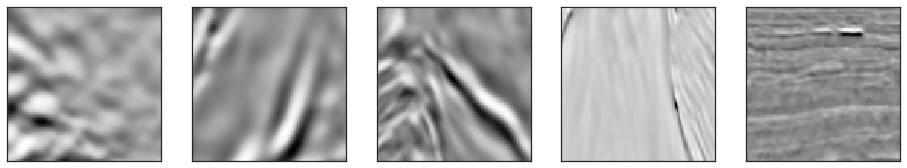

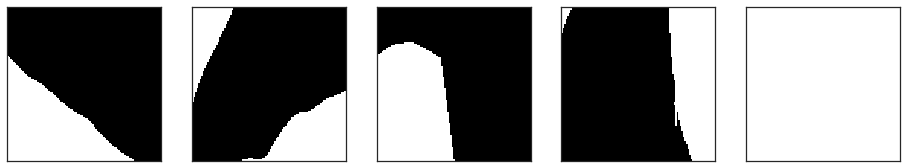

(6400, 101, 101, 1) (6400, 101, 101, 1)
1
(5, 128, 128, 2) (5, 128, 128, 1)
(5, 128, 128)
x.minmax 0.0 1.0 0.48281805300245095
y.minmax 0.0 1.0 0.5670166015625


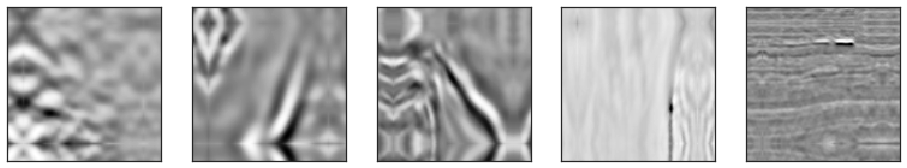

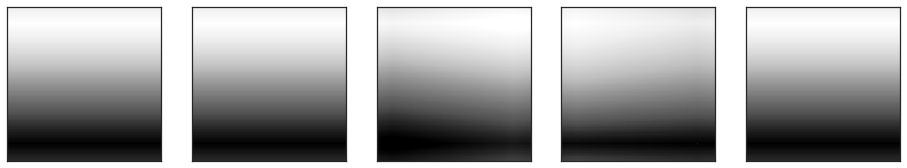

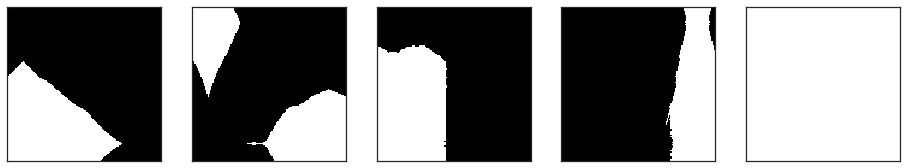

(800, 101, 101, 1) (800, 101, 101, 1)
1
(5, 128, 128, 2) (5, 128, 128, 1)
(5, 128, 128)
x.minmax 0.0 1.0 0.4766547583486519
y.minmax 0.0 1.0 0.3470947265625


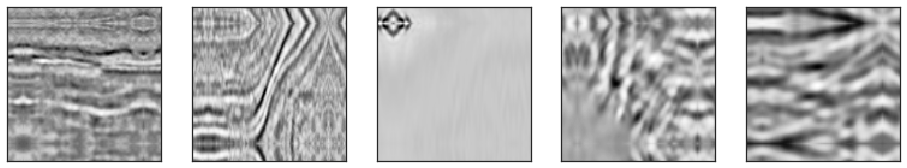

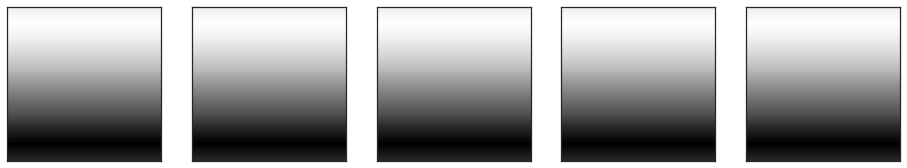

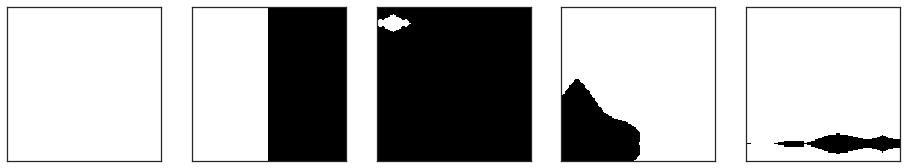

55157

In [61]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    break

rand_gen = generate_batch_data_random(X_train, Y_train, 5, shuffle=False)
i = 0
for x, y in rand_gen:
    i += 1
    print(i)
    print(x.shape, y.shape)
    print(x[:, :, :, 0].shape)
    print("x.minmax", x.min(), x.max(), x.mean())
    print("y.minmax", y.min(), y.max(), y.mean())
    plot_list(x[:, :, :, 0])
    # plot_list(x[:, :, :, 1])
    plot_list(y[:, :, :, 0])
    if i > 0:
        break

X_train = append_flip(X_train)
Y_train = append_flip(Y_train)

print(X_train.shape, Y_train.shape)
rand_gen = generate_batch_data_random_ref128depth_aug(X_train, Y_train, 5, shuffle=False)
i = 0
for x, y in rand_gen:
    i += 1
    print(i)
    print(x.shape, y.shape)
    print(x[:, :, :, 0].shape)
    print("x.minmax", x.min(), x.max(), x.mean())
    print("y.minmax", y.min(), y.max(), y.mean())
    plot_list(x[:, :, :, 0])
    plot_list(x[:, :, :, 1])
    plot_list(y[:, :, :, 0])
    if i > 0:
        break
        
del X_train, Y_train
gc.collect()

print(X_valid.shape, Y_valid.shape)
rand_gen = generate_batch_data_ref128depth(X_valid, Y_valid, 5)
i = 0
for x, y in rand_gen:
    i += 1
    print(i)
    print(x.shape, y.shape)
    print(x[:, :, :, 0].shape)
    print("x.minmax", x.min(), x.max(), x.mean())
    print("y.minmax", y.min(), y.max(), y.mean())
    plot_list(x[:, :, :, 0])
    plot_list(x[:, :, :, 1])
    plot_list(y[:, :, :, 0])
    if i > 0:
        break
        
del X_valid, Y_valid
gc.collect()

In [35]:
depth_figure.shape

(256, 256)

 6,934,295

## init stage

In [42]:
def build_stage0_model(img_size_target, builder=_build_unet34, loss=focal_loss, metric=my_iou_metric_2, opt="adam", use_sigmoid=True, start_neurons=48):
    print("local: init stage")
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = builder(input_layer, start_neurons, 0.5, use_sigmoid=use_sigmoid)
    model = Model(input_layer, output_layer)

    model.compile(loss=loss, optimizer=opt, metrics=[metric, "acc"])
    return model

### train --unet128ref-magic-basicscse --mixdrop --bcelovasz --fold0

In [93]:
run = 1
loss_name = "bcelovasz"
model_name = "unet34magicbasicscse-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    keras.backend.clear_session()
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=32, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1) # patience=8
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    X_train = append_flip(X_train)
    Y_train = append_flip(Y_train)
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    # break
    
    epochs = 100
    train_batch_size = 32
    train_steps_per_epoch = div_round(X_train.shape[0], train_batch_size)
        
    valid_batch_size = 32
    valid_steps_per_epoch = div_round(X_valid.shape[0], valid_batch_size)

    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    c = Adam(0.001)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-4)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=128, builder=_build_unet34magicscse_for256_mixdrop, opt=c, start_neurons=16, **model_params)  # start_neurons = 32
 
    print("build model.")
    # break
    
    # co = {
    #     "my_bce": my_bce,
    #     "my_iou_metric": my_iou_metric
    # }

    # model = load_model(model_filepath, custom_objects=co)
    # print("load model.")

    def train():
        return model.fit_generator(generate_batch_data_random_ref128depth(X_train, Y_train, train_batch_size),
                                   validation_data=generate_batch_data_ref128depth(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
mode: 034-model-unet34magicbasicscse-bcelovasz-stage0-fold-0-run-1.hdf5
log: 034-log-unet34magicbasicscse-bcelovasz-stage0-fold-0-run-1.csv
{'loss': <function bce_lovasz_loss at 0x000001A92A724AE8>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000001A8FFD60840>}
val_my_iou_metric
data.shape: (6400, 101, 101, 1) (6400, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 100
train_batch_size: 32
train_steps: 200
train_mult: 6400
valid_batch_size: 32
valid_steps: 25
valid_mult: 800
local: init stage
build model.
Epoch 1/100

Epoch 00001: val_my_iou_metric improved from -inf to 0.14588, saving model to 034-model-unet34magicbasicscse-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 2/100

Epoch 00002: val_my_iou_metric improved from 0.14588 to 0.55750, saving model to 034-model-unet34magicbasicscse-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 3/100

Epoch 00003: val_my_iou_metric improved from 0.55750 to 0.61000, saving model to 034-mode

KeyboardInterrupt: 

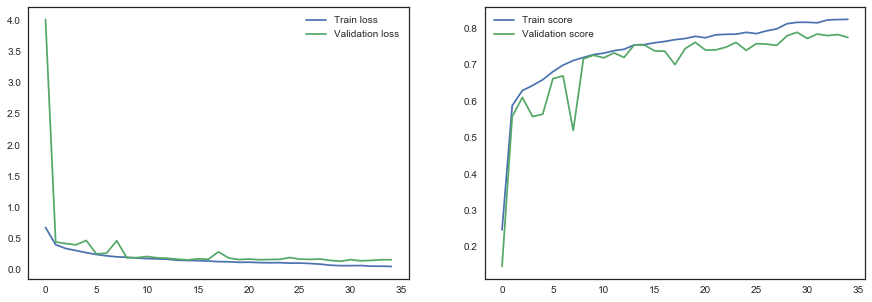

In [94]:
# 222 resnet with 128 reflect pad, flip before generator + scse

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

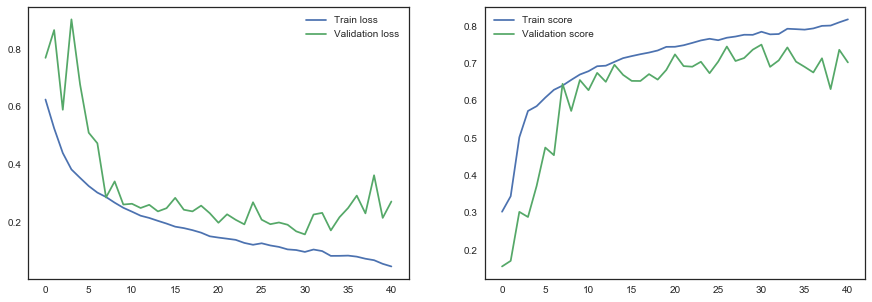

In [78]:
# 222 resnet with 128 reflect pad, flip before generator + scse

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

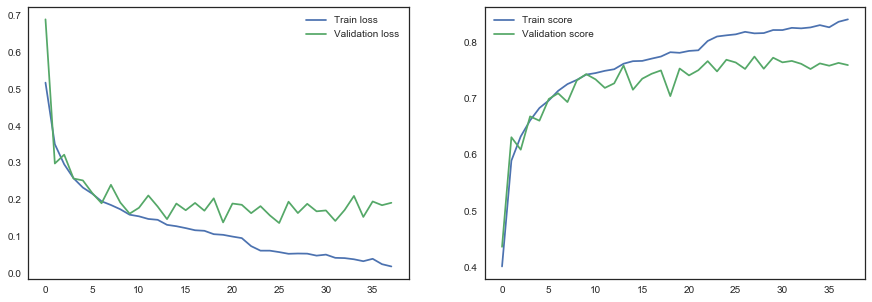

In [46]:
# 222 resnet with 128 reflect pad, flip before generator + scse

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

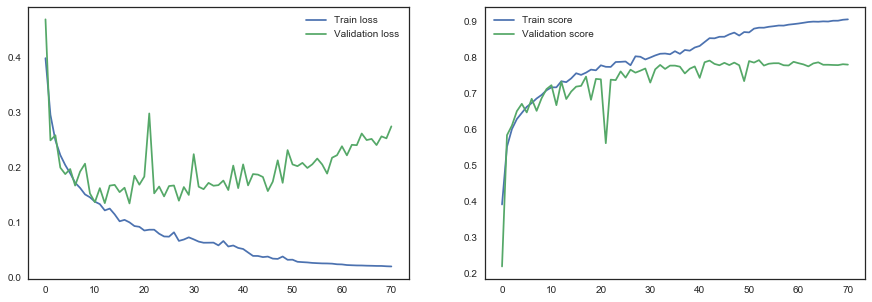

In [39]:
# 222 resnet with 128 reflect pad, flip before generator + scse

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet128ref-magic-basic --bcelovasz --fold0

In [52]:
run = 1
loss_name = "bcelovasz"
model_name = "unet34magicbasic-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    keras.backend.clear_session()
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=16, min_lr=0.00001, verbose=1) # patience=8
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    X_train = append_flip(X_train)
    Y_train = append_flip(Y_train)
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    # break
    
    epochs = 100 # 150
    train_batch_size = 20
    train_steps_per_epoch = div_round(X_train.shape[0], train_batch_size)
        
    valid_batch_size = 20
    valid_steps_per_epoch = div_round(X_valid.shape[0], valid_batch_size)

    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    c = Adam(0.001) # try 0.01
    # c = SGD(lr=0.01, momentum=.9, decay=1e-4)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=128, builder=_build_unet34magicbasic_for256, start_neurons=16, opt=c, **model_params)

    print("build model.")
    # break
    
    # co = {
    #     "my_bce": my_bce,
    #     "my_iou_metric": my_iou_metric
    # }

    # model = load_model(model_filepath, custom_objects=co)
    # print("load model.")

    def train():
        return model.fit_generator(generate_batch_data_random_ref128depth(X_train, Y_train, train_batch_size),
                                   validation_data=generate_batch_data_ref128depth(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
mode: 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
log: 034-log-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.csv
{'loss': <function bce_lovasz_loss at 0x000001A92A724AE8>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000001A8FFD60840>}
val_my_iou_metric
data.shape: (6400, 101, 101, 1) (6400, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 100
train_batch_size: 20
train_steps: 320
train_mult: 6400
valid_batch_size: 20
valid_steps: 40
valid_mult: 800
local: init stage
build model.
Epoch 1/100

Epoch 00001: val_my_iou_metric improved from -inf to 0.31425, saving model to 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 2/100

Epoch 00002: val_my_iou_metric improved from 0.31425 to 0.62475, saving model to 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 3/100

Epoch 00003: val_my_iou_metric did not improve from 0.62475
Epoch 4/100

Epoch 00004: val_my_iou_metric i

Epoch 00082: val_my_iou_metric improved from 0.80713 to 0.80737, saving model to 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 83/100

Epoch 00083: val_my_iou_metric did not improve from 0.80737
Epoch 84/100

Epoch 00084: val_my_iou_metric did not improve from 0.80737
Epoch 85/100

Epoch 00085: val_my_iou_metric did not improve from 0.80737
Epoch 86/100

Epoch 00086: val_my_iou_metric did not improve from 0.80737
Epoch 87/100

Epoch 00087: val_my_iou_metric did not improve from 0.80737
Epoch 88/100

Epoch 00088: val_my_iou_metric did not improve from 0.80737
Epoch 89/100

Epoch 00089: val_my_iou_metric did not improve from 0.80737
Epoch 90/100

Epoch 00090: val_my_iou_metric improved from 0.80737 to 0.80988, saving model to 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
Epoch 91/100

Epoch 00091: val_my_iou_metric did not improve from 0.80988
Epoch 92/100

Epoch 00092: val_my_iou_metric did not improve from 0.80988
Epoch 93/100

Epoch 00093: val_my_

034-log-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.csv


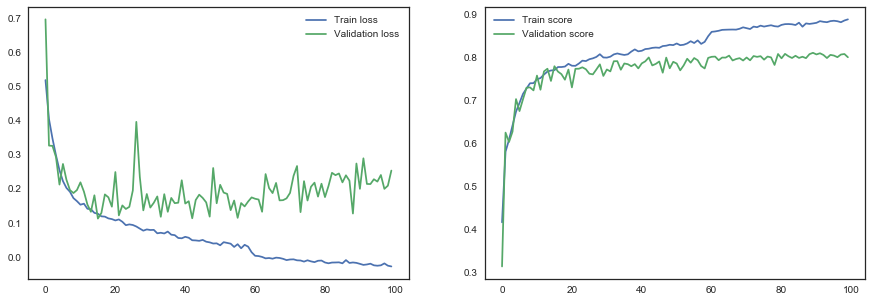

In [54]:
# 222 resnet with 128 reflect pad, flip before generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
print(log_filepath)
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

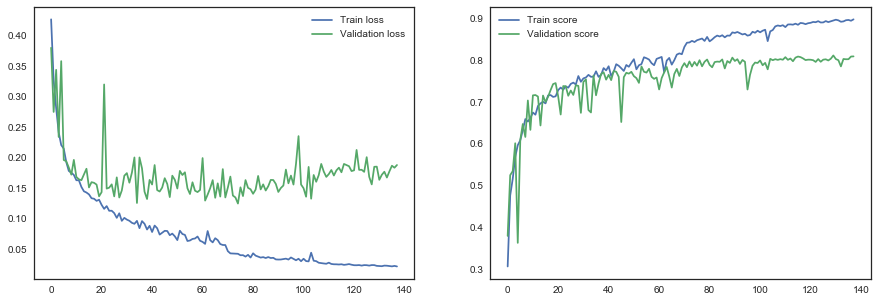

In [60]:
# 222 resnet with 128 reflect pad, flip before generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

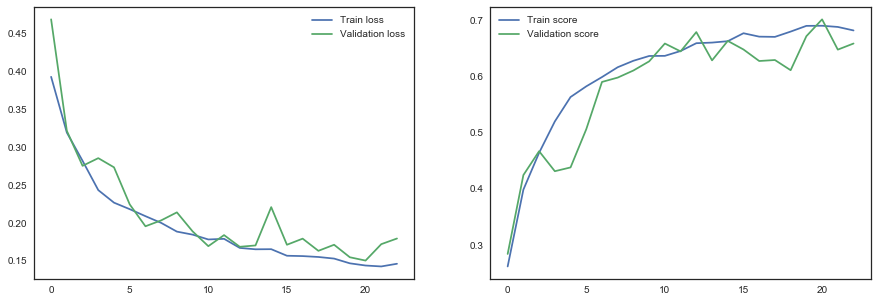

In [48]:
# 222 resnext with 128 reflect pad, flip before generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
log_filepath = "033-log-unet128ref0scse1magicfixed0conv1ref-bce-stage0-fold-0-run-1-part1.csv"
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

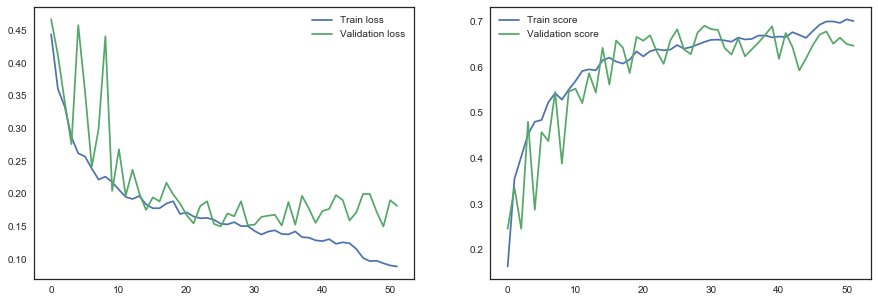

In [38]:
# 222 resnext with 128 reshape , flip with generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

In [53]:
help(UpSampling2D)

Help on class UpSampling2D in module keras.layers.convolutional:

class UpSampling2D(keras.engine.base_layer.Layer)
 |  Upsampling layer for 2D inputs.
 |  
 |  Repeats the rows and columns of the data
 |  by size[0] and size[1] respectively.
 |  
 |  # Arguments
 |      size: int, or tuple of 2 integers.
 |          The upsampling factors for rows and columns.
 |      data_format: A string,
 |          one of `"channels_last"` or `"channels_first"`.
 |          The ordering of the dimensions in the inputs.
 |          `"channels_last"` corresponds to inputs with shape
 |          `(batch, height, width, channels)` while `"channels_first"`
 |          corresponds to inputs with shape
 |          `(batch, channels, height, width)`.
 |          It defaults to the `image_data_format` value found in your
 |          Keras config file at `~/.keras/keras.json`.
 |          If you never set it, then it will be "channels_last".
 |  
 |  # Input shape
 |      4D tensor with shape:
 |      - If 

### train --unet128ref0scse1magic --bce --fold0

In [49]:
run = 1
loss_name = "bce"
model_name = "unet128ref0scse1magic0conv-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=16, min_lr=0.00001, verbose=1) # patience=16
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

    epochs = 5000
    train_batch_size = 8
    train_steps_per_epoch = X_train.shape[0] // train_batch_size
    train_mult = train_batch_size * train_steps_per_epoch
    if train_mult < X_train.shape[0]:
        train_steps_per_epoch += 1

    valid_batch_size = 16
    valid_steps_per_epoch = X_valid.shape[0] // valid_batch_size
    valid_mult = valid_batch_size * valid_steps_per_epoch
    if valid_mult < X_valid.shape[0]:
        valid_steps_per_epoch += 1
    
    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    c = Adam(0.001)
    # c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=128, builder=_build_unet34magic_for256, opt=c, **model_params)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet256_ref, opt=c, **model_params)
    print("build model.")

    def train():
        return model.fit_generator(generate128_batch_data_random(X_train, Y_train, train_batch_size),
                                   validation_data=generate128_batch_data(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
mode: 033-model-unet128ref0scse1magic0conv-bce-stage0-fold-0-run-1.hdf5
log: 033-log-unet128ref0scse1magic0conv-bce-stage0-fold-0-run-1.csv
{'loss': <function my_bce at 0x000002A1AB5FC2F0>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000002A1AB6AF2F0>}
val_my_iou_metric
data.shape: (3200, 101, 101, 1) (3200, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 5000
train_batch_size: 8
train_steps: 400
train_mult: 3200
valid_batch_size: 16
valid_steps: 50
valid_mult: 800
local: init stage
stage12_unit1_conv2 -i- (?, 130, 130, 24)
stage12_unit1_conv2 -o- (?, 128, 128, 24)
stage12_unit2_conv2 -i- (?, 130, 130, 24)
stage12_unit2_conv2 -o- (?, 128, 128, 24)
stage13_unit1_conv2 -i- (?, 66, 66, 48)
stage13_unit1_conv2 -o- (?, 64, 64, 48)
stage13_unit2_conv2 -i- (?, 66, 66, 48)
stage13_unit2_conv2 -o- (?, 64, 64, 48)
stage14_unit1_conv2 -i- (?, 34, 34, 96)
stage14_unit1_conv2 -o- (?, 32, 32, 96)
stage14_unit2_conv2 -i- (?, 34, 3

KeyboardInterrupt: 

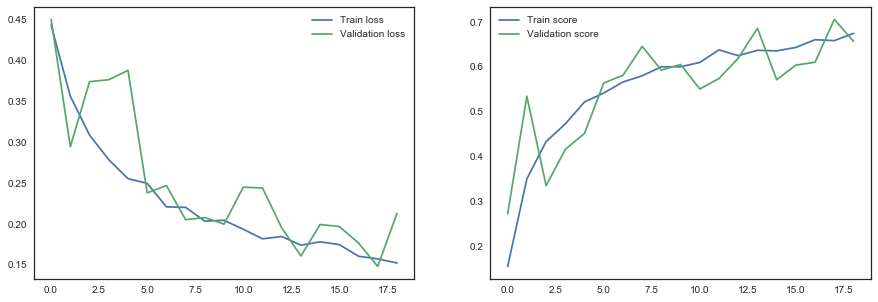

In [50]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet128ref1scse1magic --bce loss --fold0

In [58]:
run = 1
loss_name = "bcedice"
model_name = "unet128ref1scse1magic0conv-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=12, min_lr=0.00001, verbose=1) # patience=16
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

    epochs = 5000
    train_batch_size = 8
    train_steps_per_epoch = X_train.shape[0] // train_batch_size
    train_mult = train_batch_size * train_steps_per_epoch
    if train_mult < X_train.shape[0]:
        train_steps_per_epoch += 1

    valid_batch_size = 16
    valid_steps_per_epoch = X_valid.shape[0] // valid_batch_size
    valid_mult = valid_batch_size * valid_steps_per_epoch
    if valid_mult < X_valid.shape[0]:
        valid_steps_per_epoch += 1
    
    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)

    c = Adam(0.01)
    # c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=128, builder=_build_unet34scsemagic_for256, opt=c, **model_params)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet256_ref, opt=c, **model_params)
    print("build model.")

    def train():
        return model.fit_generator(generate128_batch_data_random(X_train, Y_train, train_batch_size),
                                   validation_data=generate128_batch_data(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 032-model-unet128ref1scse1magic0conv-bcedice-stage0-fold-0-run-1.hdf5
log: 032-log-unet128ref1scse1magic0conv-bcedice-stage0-fold-0-run-1.csv
{'loss': <function bce_dice_loss at 0x00000220CD02A840>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x00000220CD013840>}
val_my_iou_metric
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
epochs: 5000
train_batch_size: 8
train_steps: 400
train_mult: 3200
valid_batch_size: 16
valid_steps: 51
valid_mult: 816
local: init stage
stage12_unit1_conv2 -i- (?, 130, 130, 8)
stage12_unit1_conv2 -o- (?, 128, 128, 8)
stage12_unit2_conv2 -i- (?, 130, 130, 8)
stage12_unit2_conv2 -o- (?, 128, 128, 8)
stage13_unit1_conv2 -i- (?, 66, 66, 16)
stage13_unit1_conv2 -o- (?, 64, 64, 16)
stage13_unit2_conv2 -i- (?, 66, 66, 16)
stage13_unit2_conv2 -o- (?, 64, 64, 16)
stage13_unit3_conv2 -i- (?, 66, 66, 16)
stage13_unit3_conv2 -o- (?, 64, 64, 16)
stage14_unit1_conv2 -i

KeyboardInterrupt: 

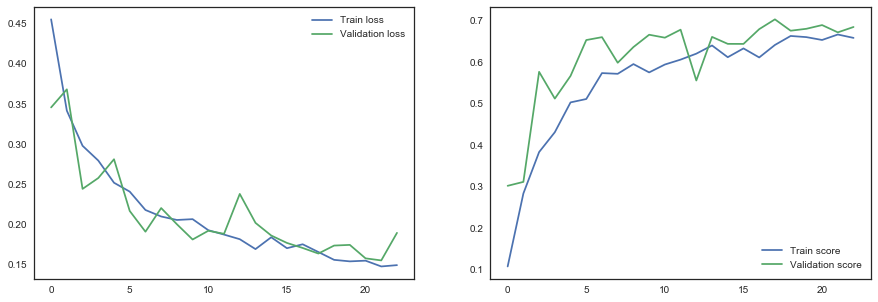

In [67]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet128 --bce loss --fold0

In [52]:
run = 1
loss_name = "bcedice"
model_name = "unet256ref0scse0magic0conv-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=16, min_lr=0.00001, verbose=1) # patience=16
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

    epochs = 5000
    train_batch_size = 8
    train_steps_per_epoch = X_train.shape[0] // train_batch_size
    train_mult = train_batch_size * train_steps_per_epoch
    if train_mult < X_train.shape[0]:
        train_steps_per_epoch += 1

    valid_batch_size = 16
    valid_steps_per_epoch = X_valid.shape[0] // valid_batch_size
    valid_mult = valid_batch_size * valid_steps_per_epoch
    if valid_mult < X_valid.shape[0]:
        valid_steps_per_epoch += 1
    
    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)

    # c = Adam(0.01)
    c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=128, builder=_build_unet34_for256, opt=c, **model_params)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet256_ref, opt=c, **model_params)
    print("build model.")

    def train():    
        return model.fit_generator(generate128_batch_data_random(X_train, Y_train, train_batch_size),
                                   validation_data=generate128_batch_data(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 032-model-unet256ref0scse0magic0conv-bcedice-stage0-fold-0-run-1.hdf5
log: 032-log-unet256ref0scse0magic0conv-bcedice-stage0-fold-0-run-1.csv
{'loss': <function bce_dice_loss at 0x00000220CD02A840>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x00000220CD013840>}
val_my_iou_metric
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
epochs: 5000
train_batch_size: 8
train_steps: 400
train_mult: 3200
valid_batch_size: 16
valid_steps: 51
valid_mult: 816
local: init stage
stage12_unit1_conv2 -i- (?, 130, 130, 16)
stage12_unit1_conv2 -o- (?, 128, 128, 16)
stage12_unit2_conv2 -i- (?, 130, 130, 16)
stage12_unit2_conv2 -o- (?, 128, 128, 16)
stage12_unit3_conv2 -i- (?, 130, 130, 16)
stage12_unit3_conv2 -o- (?, 128, 128, 16)
stage13_unit1_conv2 -i- (?, 66, 66, 32)
stage13_unit1_conv2 -o- (?, 64, 64, 32)
stage13_unit2_conv2 -i- (?, 66, 66, 32)
stage13_unit2_conv2 -o- (?, 64, 64, 32)
stage13_unit3_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda2\envs\py3\lib\site-packages\IPython\core\magics\execution.py", line 1238, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-52-453ea24c2687>", line 71, in train
    verbose=200)
  File "D:\Anaconda2\envs\py3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "D:\Anaconda2\envs\py3\lib\site-packages\keras\engine\training.py", line 1426, in fit_generator
    initial_epoch=initial_epoch)
  File "D:\Anaconda2\envs\py3\lib\site-packages\keras\engine\training_generator.py", line 191, in fit_generator
    class_weight=class_weight)
  File "D:\Anaconda2\envs\py3\lib\site-packages\keras\engine\training.py", line 1220, in train_on_batch
    outputs = self.train_function(ins)
  File "D:\Anaconda2\envs\py3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2661, in __call__
    return self._call(inputs)
  File "D:\Anaconda2\

KeyboardInterrupt: 

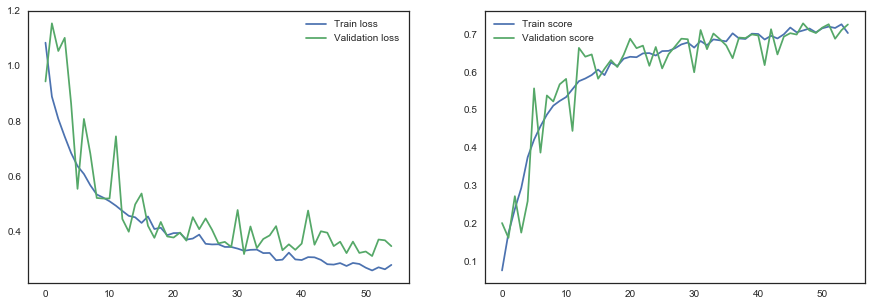

In [54]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unnet256ref --bce loss --fold0

In [43]:
run = 1
loss_name = "bcedice"
model_name = "unet256ref0scse0magic0conv-{}-stage0".format(loss_name)

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params(loss_name)
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=16, min_lr=0.00001, verbose=1) # patience=16
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

    epochs = 5000
    train_batch_size = 2
    train_steps_per_epoch = X_train.shape[0] // train_batch_size
    train_mult = train_batch_size * train_steps_per_epoch
    if train_mult < X_train.shape[0]:
        train_steps_per_epoch += 1

    valid_batch_size = 5
    valid_steps_per_epoch = X_valid.shape[0] // valid_batch_size
    valid_mult = valid_batch_size * valid_steps_per_epoch
    if valid_mult < X_valid.shape[0]:
        valid_steps_per_epoch += 1
    
    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)

    # c = Adam(0.01)
    c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, opt=c, **model_params)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet256_ref, opt=c, **model_params)
    print("build model.")

    def train():    
        return model.fit_generator(generate256_batch_data_random(X_train, Y_train, train_batch_size),
                                   validation_data=generate256_batch_data(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 032-model-unet256ref0scse0magic0conv-bcedice-stage0-fold-0-run-1.hdf5
log: 032-log-unet256ref0scse0magic0conv-bcedice-stage0-fold-0-run-1.csv
{'loss': 'binary_crossentropy', 'use_sigmoid': True, 'metric': <function my_iou_metric_2 at 0x00000220CD013EA0>}
val_my_iou_metric_2
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
epochs: 5000
train_batch_size: 2
train_steps: 1598
train_mult: 3196
valid_batch_size: 5
valid_steps: 161
valid_mult: 805
local: init stage
stage12_unit1_conv2 -i- (?, 258, 258, 16)
stage12_unit1_conv2 -o- (?, 256, 256, 16)
stage12_unit2_conv2 -i- (?, 258, 258, 16)
stage12_unit2_conv2 -o- (?, 256, 256, 16)
stage12_unit3_conv2 -i- (?, 258, 258, 16)
stage12_unit3_conv2 -o- (?, 256, 256, 16)
stage13_unit1_conv2 -i- (?, 130, 130, 32)
stage13_unit1_conv2 -o- (?, 128, 128, 32)
stage13_unit2_conv2 -i- (?, 130, 130, 32)
stage13_unit2_conv2 -o- (?, 128, 128, 32)
stage13_unit3_conv2 -i- (?,

KeyboardInterrupt: 

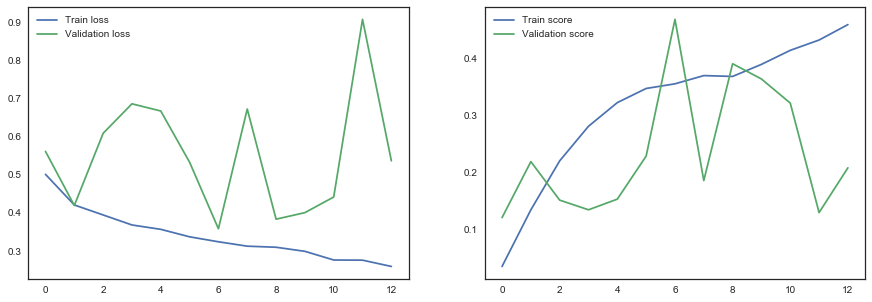

In [45]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

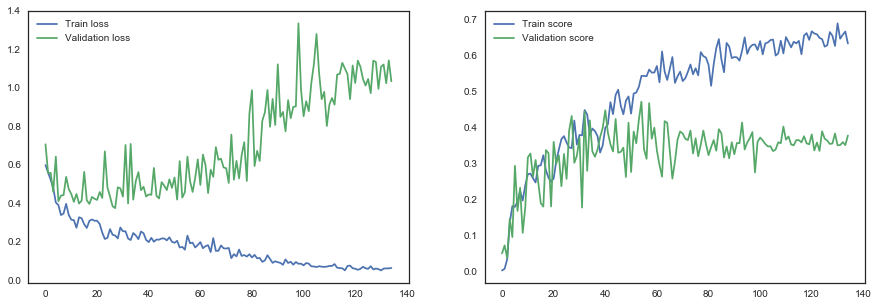

In [109]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

Error in bce dice loss

0. epoch,loss,lr,my_iou_metric,val_loss,val_my_iou_metric

1. 0,1.4534599030762911,1e-04,0.12025000000000001,1.3455692415368068,0.11426940639269408

Error in focal loss

0. epoch,loss,lr,my_iou_metric_2,val_loss,val_my_iou_metric_2

1. 0,57096.47259425595,0.01,0.37375,225205.91548052226,0.3835616438356164

2. 1,56298.41160754248,0.01,0.38625,220341.19669484874,0.3926940639269406

### train --unet --bce --fold 0

In [25]:
run = 1

model_name = "unet-bce"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_filepath = "{}-log-resnet-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_model(img_size_target=101)
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 031-model-resnet-fold-0-run-1.hdf5
log: 031-log-resnet-fold-0-run-1.csv


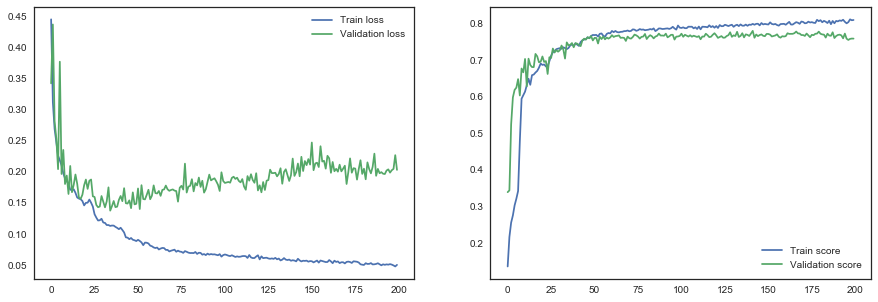

In [26]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train -thinunent --bce --fold 0

In [27]:
run = 1
model_name = "thinunet-bce-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_thinunet, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam")
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 031-model-thinunet-bce-stage0-fold-0-run-1.hdf5
log: 031-log-thinunet-bce-stage0-fold-0-run-1.csv


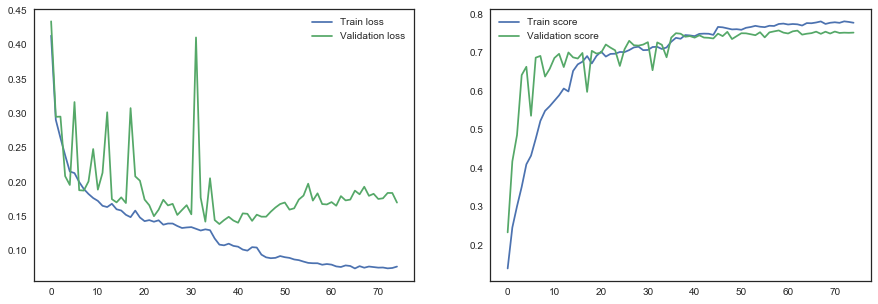

In [28]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --thinunent --bce dice loss --fold 0

BUG: dice loss with sigmoid activation at last layer

In [29]:
run = 1
model_name = "thinunet-bcedice-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_thinunet, loss=bce_dice_loss, metric=my_iou_metric_2, opt="adam")
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 031-model-thinunet-bcedice-stage0-fold-0-run-1.hdf5
log: 031-log-thinunet-bcedice-stage0-fold-0-run-1.csv


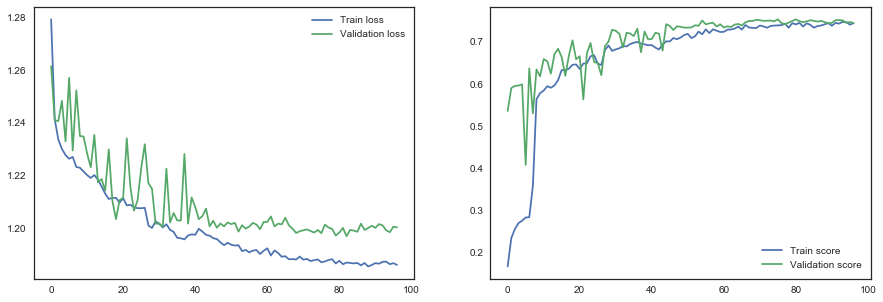

In [30]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet34 --bce dice loss --fold 0

BUG: no sigmoid with metric2

In [31]:
run = 1
model_name = "unet34-bcedice-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # c = Adadelta(0.001)
    # c = Adam(0.001)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model = build_stage0_model(img_size_target=101, builder=_build_unet34, loss=bce_dice_loss, metric=my_iou_metric_2, opt="adam", use_sigmoid=False)
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 031-model-unet34-bcedice-stage0-fold-0-run-1.hdf5
log: 031-log-unet34-bcedice-stage0-fold-0-run-1.csv


In [151]:
gc.collect()
keras.backend.clear_session()

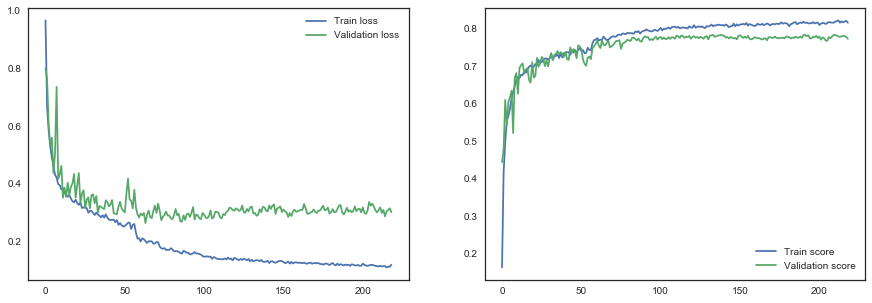

In [32]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
metric_name = "val_my_iou_metric_2"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet34 with scse --bce dice loss --fold 0

BUG FIXED: no sigmoid with metric2

In [33]:
run = 1
model_name = "unet34scse-bcedice-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    metric_name = "val_my_iou_metric" # !?
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_unet34_scse, loss=bce_dice_loss, metric=my_iou_metric, opt="adam", use_sigmoid=False)
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 031-model-unet34scse-bcedice-stage0-fold-0-run-1.hdf5
log: 031-log-unet34scse-bcedice-stage0-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
stage12_unit1_conv2 -i- (?, 103, 103, 16)
stage12_unit1_conv2 -o- (?, 101, 101, 16)
stage12_unit2_conv2 -i- (?, 103, 103, 16)
stage12_unit2_conv2 -o- (?, 101, 101, 16)
stage12_unit3_conv2 -i- (?, 103, 103, 16)
stage12_unit3_conv2 -o- (?, 101, 101, 16)
stage13_unit1_conv2 -i- (?, 52, 52, 32)
stage13_unit1_conv2 -o- (?, 50, 50, 32)
stage13_unit2_conv2 -i- (?, 52, 52, 32)
stage13_unit2_conv2 -o- (?, 50, 50, 32)
stage13_unit3_conv2 -i- (?, 52, 52, 32)
stage13_unit3_conv2 -o- (?, 50, 50, 32)
stage13_unit4_conv2 -i- (?, 52, 52, 32)
stage13_unit4_conv2 -o- (?, 50, 50, 32)
stage14_unit1_conv2 -i- (?, 27, 27, 64)
stage14_unit1_conv2 -o- (?, 25, 25, 64)
stage14_unit2_conv2 -i- (?, 27, 27, 64)
stage14_unit2_conv2 -o- (?, 25, 25, 64)
stage14_unit3_conv2

KeyboardInterrupt: 

In [45]:
gc.collect()
keras.backend.clear_session()

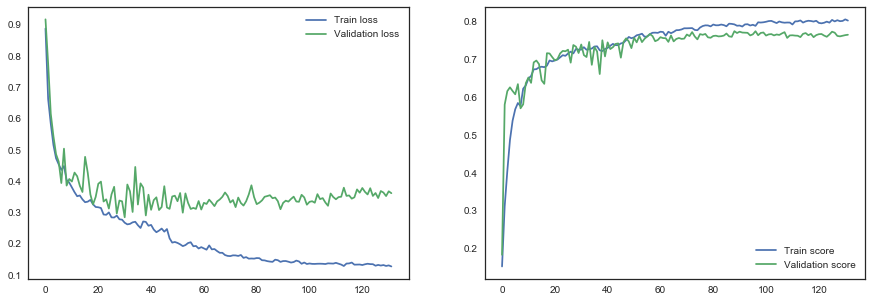

In [34]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### train --unet --focal loss --fold 0

In [ ]:
run = 1
model_name = "unet-focal-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_unet, loss=focal_loss, metric=my_iou_metric_2, opt="adam")
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

### train --linknet --focal loss --fold 0

In [ ]:
run = 1
model_name = "linknet-focal-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_linknet, loss=focal_loss, metric=my_iou_metric_2, opt="adam")
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

### train --unnet with scse -- focal loss --fold 0

In [ ]:
run = 1
model_name = "unetscse-focal-stage0"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric_2"
    break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model = build_stage0_model(img_size_target=101, builder=_build_unet_scse, loss=focal_loss, metric=my_iou_metric_2, opt="adam")
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

## finetune stage

In [45]:
def load_model_bce2lovasz(filename):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # print(model_pretrained.summary())
    
    model_rebuild = Model(model_pretrained.layers[0].input, model_pretrained.layers[-1].input)
    
    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild

In [46]:
def load_model_mybce2lovasz(filename, opt):
    co = {
        "my_bce": my_bce,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    model_pretrained.compile(loss=lovasz_loss_elu, optimizer=opt, metrics=[my_iou_metric])
    return model_pretrained

In [63]:
def load_model_bcelovasz2lovasz(filename, opt):
    co = {
        "bce_lovasz_loss": bce_lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    model_pretrained.compile(loss=lovasz_loss_elu, optimizer=opt, metrics=[my_iou_metric])
    return model_pretrained

In [47]:
def load_model_dice2lovasz(filename, opt):
    co = {
        "bce_dice_loss": bce_dice_loss,
        "my_iou_metric": my_iou_metric,
        "my_iou_metric_2": my_iou_metric_2
    }
    
    model_pretrained = load_model(filename, custom_objects=co)
    print(model_pretrained.layers[-1].get_config())
    model_pretrained.compile(loss=lovasz_loss_elu, optimizer=opt, metrics=[my_iou_metric])
    return model_pretrained

### finetune0 --unet128ref-magic-basicscse --lovasz loss --fold0

In [96]:
run = 1
loss_name = "bcelovasz"
pre_model_name = "unet34magicbasicscse-{}-stage0".format(loss_name)
model_name = pre_model_name.replace(loss_name, "lovasz").replace("stage0", "stage1")

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    keras.backend.clear_session()
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    pre_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, pre_model_name, i, run)
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("pretrained:", pre_model_filepath)
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params("lovasz")
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1) # patience=8
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    X_train = append_flip(X_train)
    Y_train = append_flip(Y_train)
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    epochs = 200
    train_batch_size = 32
    train_steps_per_epoch = div_round(X_train.shape[0], train_batch_size)
        
    valid_batch_size = 32
    valid_steps_per_epoch = div_round(X_valid.shape[0], valid_batch_size)

    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    c = Adam(0.001)
    # c = SGD(lr=0.005, momentum=.9, decay=1e-3)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    # model = load_model_mybce2lovasz(pre_model_filepath, c)  # start_neurons = 32
    model = load_model_bcelovasz2lovasz(pre_model_filepath, c)  # start_neurons = 32
    print("load model.")
    # break
    
    # co = {
    #     "my_bce": my_bce,
    #     "my_iou_metric": my_iou_metric
    # }

    # model = load_model(model_filepath, custom_objects=co)
    # print("load model.")

    def train():
        return model.fit_generator(generate_batch_data_random_ref128depth_aug(X_train, Y_train, train_batch_size),
                                   validation_data=generate_batch_data_ref128depth(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
pretrained: 034-model-unet34magicbasicscse-bcelovasz-stage0-fold-0-run-1.hdf5
mode: 034-model-unet34magicbasicscse-lovasz-stage1-fold-0-run-1.hdf5
log: 034-log-unet34magicbasicscse-lovasz-stage1-fold-0-run-1.csv
{'loss': <function lovasz_loss at 0x000001A8FFD60BF8>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000001A8FFD60840>}
val_my_iou_metric
data.shape: (6400, 101, 101, 1) (6400, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 200
train_batch_size: 32
train_steps: 200
train_mult: 6400
valid_batch_size: 32
valid_steps: 25
valid_mult: 800
load model.
Epoch 1/200

Epoch 00001: val_my_iou_metric improved from -inf to 0.76675, saving model to 034-model-unet34magicbasicscse-lovasz-stage1-fold-0-run-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric did not improve from 0.76675
Epoch 3/200

Epoch 00003: val_my_iou_metric improved from 0.76675 to 0.77288, saving model to 034-model-unet34magicbasicscse-lovasz-stage1-fold

Epoch 00085: val_my_iou_metric did not improve from 0.79625
Epoch 86/200

Epoch 00086: val_my_iou_metric did not improve from 0.79625
Epoch 87/200

Epoch 00087: val_my_iou_metric did not improve from 0.79625
Epoch 88/200

Epoch 00088: val_my_iou_metric did not improve from 0.79625
Epoch 89/200

Epoch 00089: val_my_iou_metric did not improve from 0.79625
Epoch 90/200

Epoch 00090: val_my_iou_metric did not improve from 0.79625

Epoch 00090: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 91/200

Epoch 00091: val_my_iou_metric did not improve from 0.79625
Epoch 92/200

Epoch 00092: val_my_iou_metric did not improve from 0.79625
Epoch 93/200

Epoch 00093: val_my_iou_metric did not improve from 0.79625
Epoch 94/200

Epoch 00094: val_my_iou_metric did not improve from 0.79625
Epoch 95/200

Epoch 00095: val_my_iou_metric did not improve from 0.79625
Epoch 96/200

Epoch 00096: val_my_iou_metric did not improve from 0.79625
Epoch 97/200

Epoch 00097: val_my_iou_metric did not improve 

034-log-unet34magicbasicscse-lovasz-stage1-fold-0-run-1.csv


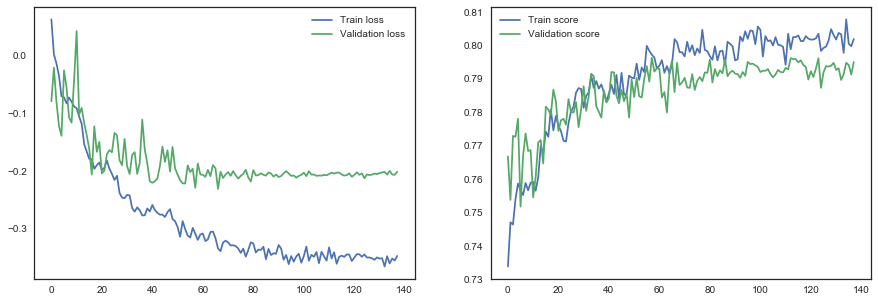

In [97]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
print(log_filepath)
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### finetune0 --unet128ref-magic-basic --lovasz loss --aug --fold0

In [49]:
keras.backend.clear_session()

In [67]:
run = 1
loss_name = "bcelovasz"
pre_model_name = "unet34magicbasic-{}-stage0".format(loss_name)
model_name = pre_model_name.replace(loss_name, "lovasz").replace("stage0", "stage1")

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    keras.backend.clear_session()
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    pre_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, pre_model_name, i, run)
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("pretrained:", pre_model_filepath)
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params("lovasz")
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=48, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=16, min_lr=0.0001, verbose=1) # patience=15 , 6
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    X_train = append_flip(X_train)
    Y_train = append_flip(Y_train)
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    epochs = 200
    train_batch_size = 32
    train_steps_per_epoch = div_round(X_train.shape[0], train_batch_size)
        
    valid_batch_size = 32
    valid_steps_per_epoch = div_round(X_valid.shape[0], valid_batch_size)

    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    # c = Adam(0.001)
    c = SGD(lr=0.005, momentum=.9, decay=1e-3)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    model = load_model_bcelovasz2lovasz(pre_model_filepath, c)  # start_neurons = 32
    print("load model.")
    # break
    
    # co = {
    #     "my_bce": my_bce,
    #     "my_iou_metric": my_iou_metric
    # }

    # model = load_model(model_filepath, custom_objects=co)
    # print("load model.")

    def train():
        return model.fit_generator(generate_batch_data_random_ref128depth_aug(X_train, Y_train, train_batch_size),
                                   validation_data=generate_batch_data_ref128depth(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
pretrained: 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
mode: 034-model-unet34magicbasic-lovasz-stage1-fold-0-run-1.hdf5
log: 034-log-unet34magicbasic-lovasz-stage1-fold-0-run-1.csv
{'loss': <function lovasz_loss at 0x000001A8FFD60BF8>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000001A8FFD60840>}
val_my_iou_metric
data.shape: (6400, 101, 101, 1) (6400, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 200
train_batch_size: 32
train_steps: 200
train_mult: 6400
valid_batch_size: 32
valid_steps: 25
valid_mult: 800
load model.
Epoch 1/200

Epoch 00001: val_my_iou_metric improved from -inf to 0.77475, saving model to 034-model-unet34magicbasic-lovasz-stage1-fold-0-run-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric improved from 0.77475 to 0.78537, saving model to 034-model-unet34magicbasic-lovasz-stage1-fold-0-run-1.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric improved from 0.78537 to 0.79275, s

KeyboardInterrupt: 

034-log-unet34magicbasic-lovasz-stage1-fold-0-run-1.csv


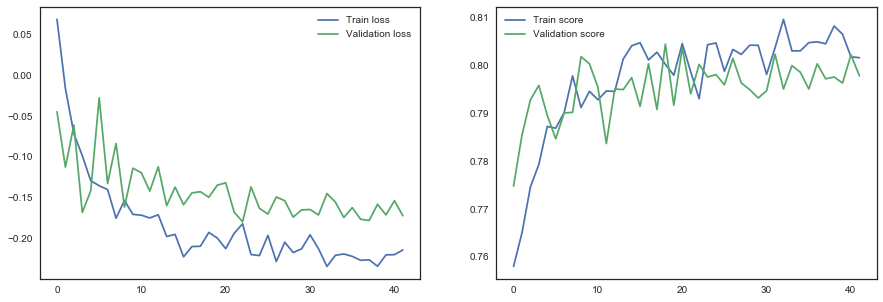

In [71]:
# 222 resnet with 128 reflect pad, flip before generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
log_filepath = "034-log-unet34magicbasic-lovasz-stage1-fold-0-run-1.csv"
print(log_filepath)
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

034-log-unet34magicbasic-lovasz-stage1-fold-0-run-1.csv


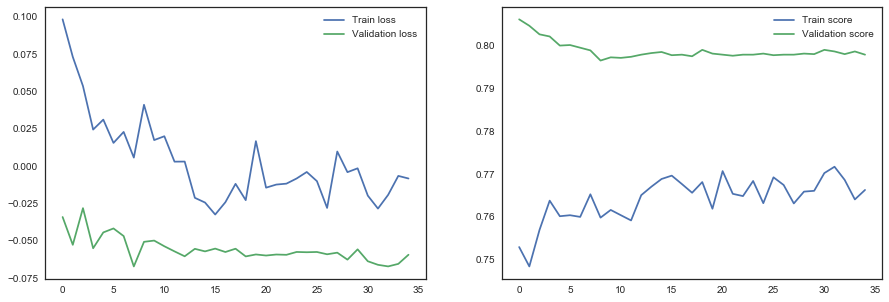

In [65]:
# 222 resnet with 128 reflect pad, flip before generator

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
# log_filepath = "033-log-unet34magicbasic-bce-stage0-fold-0-run-1.csv"
print(log_filepath)
history = pd.read_csv(log_filepath)
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### finetune1 --unet128ref-magic-basic --lovasz loss --aug --fold0

In [75]:
run = 1
loss_name = "bcelovasz"
stage0_model_name = "unet34magicbasic-{}-stage0".format(loss_name)
stage1_model_name = stage0_model_name.replace(loss_name, "lovasz").replace("stage0", "stage1")
model_name = stage1_model_name.replace("stage1", "stage2")

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    keras.backend.clear_session()
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    stage0_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, stage0_model_name, i, run)
    stage1_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, stage1_model_name, i, run)
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("stage0:", stage0_model_filepath)
    print("stage1:", stage1_model_filepath)
    print("mode:", model_filepath)
    print("log:", log_filepath)
    # metric_name = "val_my_iou_metric_2"
    model_params, metric_name = get_model_params("lovasz")
    metric_name = "val_" + metric_name
    
    print(model_params)
    print(metric_name)
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=48, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=6, min_lr=0.0001, verbose=1) # patience=15 , 6
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    X_train = append_flip(X_train)
    Y_train = append_flip(Y_train)
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    epochs = 200
    train_batch_size = 32
    train_steps_per_epoch = div_round(X_train.shape[0], train_batch_size)
        
    valid_batch_size = 32
    valid_steps_per_epoch = div_round(X_valid.shape[0], valid_batch_size)

    print("epochs:", epochs)
    print("train_batch_size:", train_batch_size)
    print("train_steps:", train_steps_per_epoch)
    print("train_mult:", train_batch_size * train_steps_per_epoch)

    print("valid_batch_size:", valid_batch_size)
    print("valid_steps:", valid_steps_per_epoch)
    print("valid_mult:", valid_batch_size * valid_steps_per_epoch)
    # break

    # c = Adam(0.001)
    c = SGD(lr=0.001, momentum=.9, decay=1e-3)
    # model = build_stage0_model(img_size_target=256, builder=_build_unet34_for256, loss="binary_crossentropy", metric=my_iou_metric_2, opt="adam", use_sigmoid=True)
    # model = load_model_bcelovasz2lovasz(pre_model_filepath, c)  # start_neurons = 32
    model = load_model(stage1_model_filepath, custom_objects={"lovasz_loss_elu": lovasz_loss_elu, "my_iou_metric": my_iou_metric})
    model.compile(optimizer=c, loss=lovasz_loss_elu, metrics=[my_iou_metric])
    print("load model.")
    # break
    
    # co = {
    #     "my_bce": my_bce,
    #     "my_iou_metric": my_iou_metric
    # }

    # model = load_model(model_filepath, custom_objects=co)
    # print("load model.")

    def train():
        return model.fit_generator(generate_batch_data_random_ref128depth(X_train, Y_train, train_batch_size), # no augment
                                   validation_data=generate_batch_data_ref128depth(X_valid, Y_valid, valid_batch_size), 
                                   epochs=epochs,
                                   steps_per_epoch=train_steps_per_epoch,
                                   callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                   validation_steps=valid_steps_per_epoch,
                                   verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3200,) (800,)
stage0: 034-model-unet34magicbasic-bcelovasz-stage0-fold-0-run-1.hdf5
stage1: 034-model-unet34magicbasic-lovasz-stage1-fold-0-run-1.hdf5
mode: 034-model-unet34magicbasic-lovasz-stage2-fold-0-run-1.hdf5
log: 034-log-unet34magicbasic-lovasz-stage2-fold-0-run-1.csv
{'loss': <function lovasz_loss at 0x000001A8FFD60BF8>, 'use_sigmoid': False, 'metric': <function my_iou_metric at 0x000001A8FFD60840>}
val_my_iou_metric
data.shape: (6400, 101, 101, 1) (6400, 101, 101, 1) (800, 101, 101, 1) (800, 101, 101, 1)
epochs: 200
train_batch_size: 32
train_steps: 200
train_mult: 6400
valid_batch_size: 32
valid_steps: 25
valid_mult: 800
load model.
Epoch 1/200

Epoch 00001: val_my_iou_metric improved from -inf to 0.80450, saving model to 034-model-unet34magicbasic-lovasz-stage2-fold-0-run-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric improved from 0.80450 to 0.80513, saving model to 034-model-unet34magicbasic-lovasz-stage2-fold-0-run-1.hdf5
Epoch 3/200

Epo

Epoch 00087: val_my_iou_metric did not improve from 0.81250
Epoch 88/200

Epoch 00088: val_my_iou_metric did not improve from 0.81250
Epoch 89/200

Epoch 00089: val_my_iou_metric did not improve from 0.81250
Epoch 90/200

Epoch 00090: val_my_iou_metric did not improve from 0.81250
Epoch 91/200

Epoch 00091: val_my_iou_metric did not improve from 0.81250
Epoch 92/200

Epoch 00092: val_my_iou_metric did not improve from 0.81250
Epoch 93/200

Epoch 00093: val_my_iou_metric did not improve from 0.81250
Epoch 94/200

Epoch 00094: val_my_iou_metric did not improve from 0.81250
Epoch 95/200

Epoch 00095: val_my_iou_metric did not improve from 0.81250
Epoch 96/200

Epoch 00096: val_my_iou_metric did not improve from 0.81250
Epoch 97/200

Epoch 00097: val_my_iou_metric did not improve from 0.81250
Epoch 98/200

Epoch 00098: val_my_iou_metric did not improve from 0.81250
Epoch 99/200

Epoch 00099: val_my_iou_metric did not improve from 0.81250
Epoch 100/200

Epoch 00100: val_my_iou_metric did no

### finetune0 --unet34 --lovasz loss --no generator --fold0

In [46]:
run = 1
pre_model_name = "unet34-bcedice-stage0"
model_name = "unet34-lovasz-stage1"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    pre_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, pre_model_name, i, run)
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("pre_mode:", pre_model_filepath)
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric"
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # c = Adadelta(0.001)
    opt = Adam(0.0001)
    # opt = SGD(lr=0.0001, momentum=.9, decay=1e-6)
    # opt = SGD(lr=0.00005, momentum=.9, decay=1e-6)
    model = load_model_dice2lovasz(pre_model_filepath, opt)
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
pre_mode: 031-model-unet34-bcedice-stage0-fold-0-run-1.hdf5
mode: 031-model-unet34-lovasz-stage1-fold-0-run-1.hdf5
log: 031-log-unet34-lovasz-stage1-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
{'name': 'final_conv', 'trainable': True, 'filters': 1, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/500

Epoch 00001: val_my_iou_metric improved from -inf to 0.34291, saving model

KeyboardInterrupt: 

031-log-unet34-lovasz-stage1-fold-0-run-1.csv


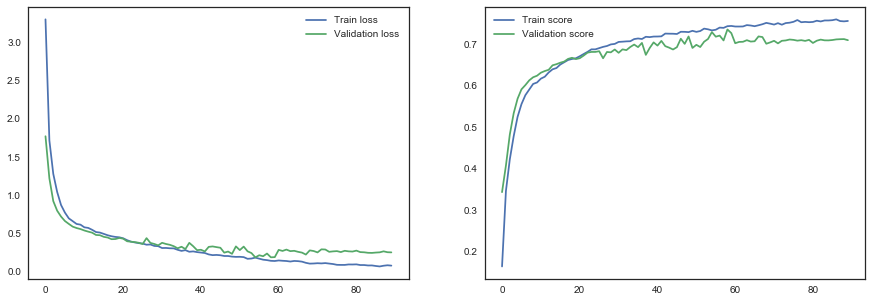

In [49]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
print(log_filepath)
metric_name = "val_my_iou_metric"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

### finetune0 --unet34scse --lovasz loss --no generator --fold0

In [50]:
run = 1
pre_model_name = "unet34scse-bcedice-stage0"
model_name = "unet34scse-lovasz-stage1"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    pre_model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, pre_model_name, i, run)
    model_filepath = "{}-model-{}-fold-{}-run-{}.hdf5".format(exp_code, model_name, i, run)
    log_filepath = "{}-log-{}-fold-{}-run-{}.csv".format(exp_code, model_name, i, run)
    
    print("pre_mode:", pre_model_filepath)
    print("mode:", model_filepath)
    print("log:", log_filepath)
    metric_name = "val_my_iou_metric"
    # break

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=80, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # c = Adadelta(0.001)
    # opt = Adam(0.001)
    # opt = SGD(lr=0.00005, momentum=.9, decay=1e-6)
    opt = Adam(0.0001)
    model = load_model_dice2lovasz(pre_model_filepath, opt)
    print("build model.")

    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
pre_mode: 031-model-unet34scse-bcedice-stage0-fold-0-run-1.hdf5
mode: 031-model-unet34scse-lovasz-stage1-fold-0-run-1.hdf5
log: 031-log-unet34scse-lovasz-stage1-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
{'name': 'final_conv', 'trainable': True, 'filters': 1, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/500

Epoch 00001: val_my_iou_metric improved from -inf to 0.31990, 

KeyboardInterrupt: 

031-log-unet34scse-lovasz-stage1-fold-0-run-1.csv


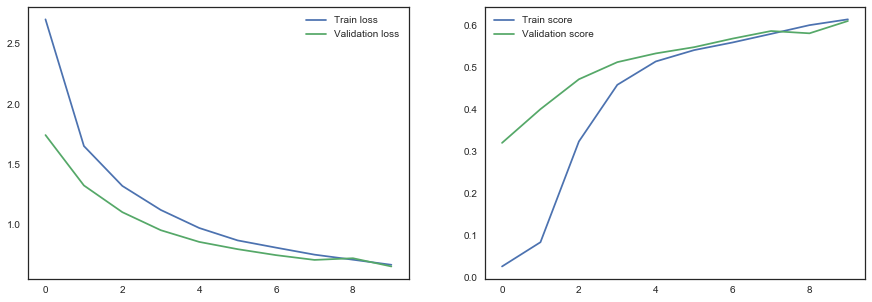

In [51]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

history = pd.read_csv(log_filepath)
print(log_filepath)
metric_name = "val_my_iou_metric"
ax_loss.plot(history.epoch, history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history[metric_name[4:]], label="Train score")
ax_score.plot(history.epoch, history[metric_name], label="Validation score")
ax_score.legend()
plt.show()

## previous models

## finetune0 --fold 0 --branch no scse block

In [118]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format("029", i, run) # previous
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)
    
    # model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i)
    # model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    # log_finetune0_filepath = "{}-log-resnet-finetune0-fold-{}.csv".format(exp_code, i)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    # break
    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_bce2lovasz(model_filepath)
    print("build model.")
    
    def train():    
        return model_rebuild.fit_generator(generate_batch_data_random(X_train, Y_train, batch_size),
                                           validation_data=generate_batch_data(X_valid, Y_valid, 50), 
                                           epochs=5000,
                                           steps_per_epoch=100,
                                           callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                           validation_steps=17,
                                           verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 030-model-resnet-finetune0-fold-0-run-1.hdf5
log: 030-log-resnet-finetune0--fold-0-run-1.csv
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
build model.
Epoch 1/5000

Epoch 00001: val_my_iou_metric improved from -inf to 0.78047, saving model to 030-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 2/5000

Epoch 00002: val_my_iou_metric improved from 0.78047 to 0.78333, saving model to 030-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 3/5000

Epoch 00003: val_my_iou_metric improved from 0.78333 to 0.78694, saving model to 030-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 4/5000

Epoch 00004: val_my_iou_metric did not improve from 0.78694
Epoch 5/5000

Epoch 00005: val_my_iou_metric improved from 0.78694 to 0.78781, saving model to 030-model-resnet-finetune0-fold-0-run-1.hdf5
Epoch 6/5000

Epoch 00006: val_my_iou_metric did not improve from 0.7878

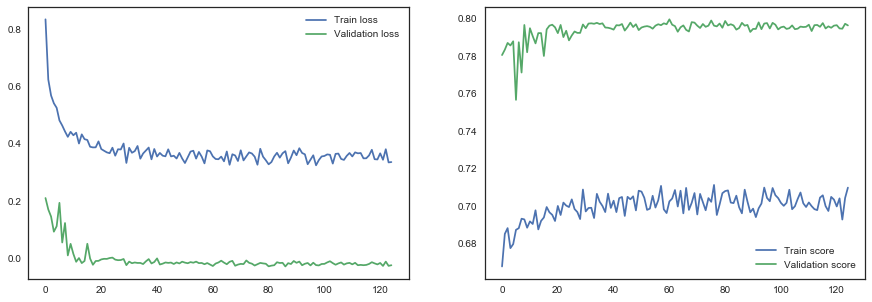

In [119]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

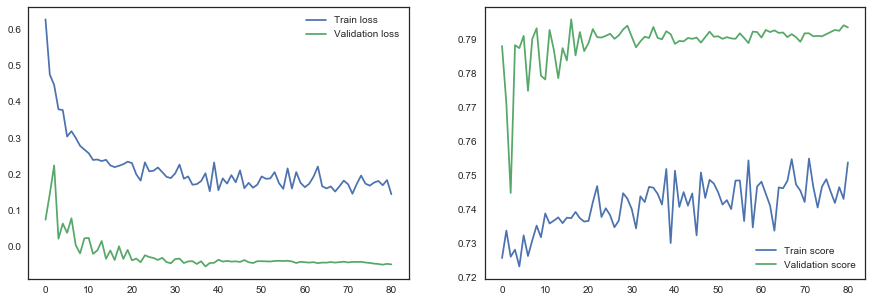

In [107]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

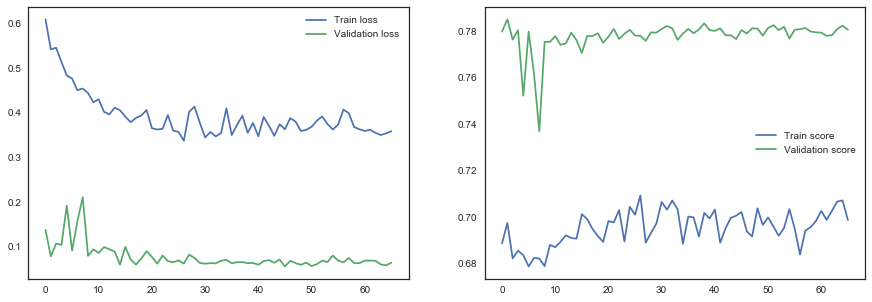

In [102]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

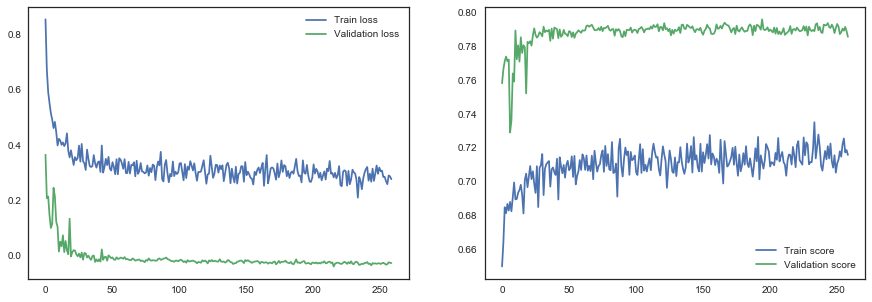

In [77]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

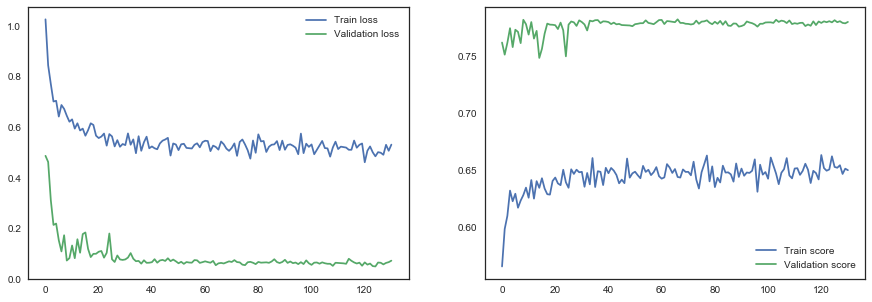

In [68]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

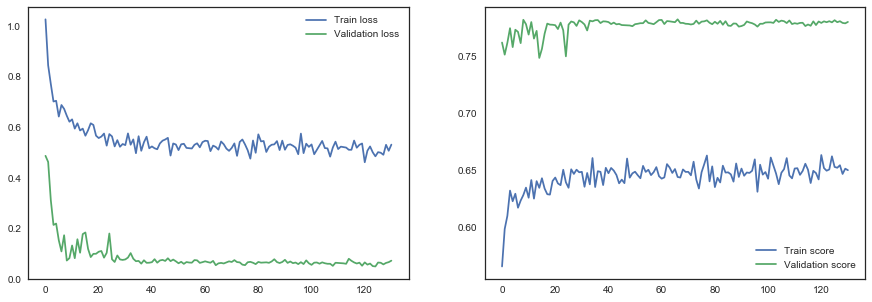

In [67]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

## change structure --copy & freeze

In [86]:
def build_model_with_scblock(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = _build_model(input_layer, 16, 0.5, use_se=True, use_sigmoid=False, ssigmoid=False, se_l2_alpha=0.00001)

    model = Model(input_layer, output_layer)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    # model.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model


def build_model_with_scblock2(img_size_target):
    input_layer = Input((img_size_target, img_size_target, 2), name="input")
    output_layer = _build_model(input_layer, 16, 0.5, use_se=True, use_sigmoid=False, ssigmoid=True, se_l2_alpha=0.00001)

    model = Model(input_layer, output_layer)
    # c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    # model.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model


def copy_weights(target_model, source_model, freeze=False):
    for layer in source_model.layers:
        layer_name = layer.get_config()["name"]
        if "_conv" in layer_name or "_bn" in layer_name:
            print(layer_name)
            source_layer = source_model.get_layer(layer_name)
            target_layer = target_model.get_layer(layer_name)
            weights = source_layer.get_weights()
            target_layer.set_weights(weights)
            target_layer.trainable = not(freeze)


def load_model_add_scblock(filename, copy=False, freeze=False):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    
    model_rebuild = build_model_with_scblock(101)
    if copy:
        model_pretrained = load_model(filename, custom_objects=co)
        copy_weights(model_rebuild, model_pretrained, freeze=freeze)

    c = SGD(lr=0.01, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild


def load_model_add_scblock2(filename, freeze=False):
    co = {
        "my_iou_metric_2": my_iou_metric_2
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    model_rebuild = build_model_with_scblock2(101)
    copy_weights(model_rebuild, model_pretrained, freeze=freeze)

    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_rebuild.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_rebuild

In [46]:
model = build_model_with_scblock(img_size_target)

In [50]:
# del model
gc.collect()
keras.backend.clear_session()

In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 101, 2)  0                                            
__________________________________________________________________________________________________
en1_a_conv (Conv2D)             (None, 101, 101, 16) 304         input[0][0]                      
__________________________________________________________________________________________________
en1_b_relu (Activation)         (None, 101, 101, 16) 0           en1_a_conv[0][0]                 
__________________________________________________________________________________________________
en1_b_bn (BatchNormalization)   (None, 101, 101, 16) 64          en1_b_relu[0][0]                 
__________________________________________________________________________________________________
en1_b_1_co

__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 25, 25, 1)    0           activation_33[0][0]              
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 1, 1, 32)     0           activation_31[0][0]              
__________________________________________________________________________________________________
conv2d_transpose_11 (Conv2DTran (None, 50, 50, 1)    10          reshape_9[0][0]                  
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 50, 50, 32)   0           en2_b_2_bn[0][0]                 
                                                                 reshape_7[0][0]                  
__________________________________________________________________________________________________
multiply_6

__________________________________________________________________________________________________
dense_24 (Dense)                (None, 625)          98125       activation_45[0][0]              
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 64)           0           dense_22[0][0]                   
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 625)          0           dense_24[0][0]                   
__________________________________________________________________________________________________
reshape_16 (Reshape)            (None, 1, 1, 64)     0           activation_44[0][0]              
__________________________________________________________________________________________________
reshape_18 (Reshape)            (None, 25, 25, 1)    0           activation_46[0][0]              
__________

vm_c_1_conv (Conv2D)            (None, 6, 6, 256)    590080      vm_c_bn[0][0]                    
__________________________________________________________________________________________________
vm_c_1_bn (BatchNormalization)  (None, 6, 6, 256)    1024        vm_c_1_conv[0][0]                
__________________________________________________________________________________________________
vm_c_1_relu (Activation)        (None, 6, 6, 256)    0           vm_c_1_bn[0][0]                  
__________________________________________________________________________________________________
vm_c_2_conv (Conv2D)            (None, 6, 6, 256)    590080      vm_c_1_relu[0][0]                
__________________________________________________________________________________________________
vm_c_2_bn (BatchNormalization)  (None, 6, 6, 256)    1024        vm_c_2_conv[0][0]                
__________________________________________________________________________________________________
vm_c_add (

__________________________________________________________________________________________________
activation_69 (Activation)      (None, 156)          0           dense_43[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 64)           1088        activation_67[0][0]              
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 625)          98125       activation_69[0][0]              
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 64)           0           dense_42[0][0]                   
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 625)          0           dense_44[0][0]                   
__________

reshape_41 (Reshape)            (None, 625)          0           max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
global_max_pooling2d_14 (Global (None, 32)           0           de2_c_2_bn[0][0]                 
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 156)          97656       reshape_41[0][0]                 
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 8)            264         global_max_pooling2d_14[0][0]    
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 156)          0           dense_55[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
final_conv (Conv2D)             (None, 101, 101, 1)  17          dropout_27[0][0]                 
Total params: 7,560,349
Trainable params: 7,551,517
Non-trainable params: 8,832
__________________________________________________________________________________________________


## finetune0 --fold 0 --branch with scse block freeze unet

In [87]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format("029", i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-block1-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0-block1-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    # model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i)
    # model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    # log_finetune0_filepath = "{}-log-resnet-finetune0-fold-{}.csv".format(exp_code, i)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1) # reduce 2 16
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 1000
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_add_scblock(model_filepath, copy=True, freeze=True)
    print("build model.")
    
    def train():    
        return model_rebuild.fit_generator(generate_batch_data_random(X_train, Y_train, batch_size),
                                           validation_data=generate_batch_data(X_valid, Y_valid, 50), 
                                           epochs=5000,
                                           steps_per_epoch=100,
                                           callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                           validation_steps=17,
                                           verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 030-model-resnet-finetune0-block1-fold-0-run-1.hdf5
log: 030-log-resnet-finetune0-block1-fold-0-run-1.csv
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
en1_a_conv
en1_b_bn
en1_b_1_conv
en1_b_1_bn
en1_b_2_conv
en1_b_2_bn
en1_c_bn
en1_c_1_conv
en1_c_1_bn
en1_c_2_conv
en1_c_2_bn
en2_a_conv
en2_b_bn
en2_b_1_conv
en2_b_1_bn
en2_b_2_conv
en2_b_2_bn
en2_c_bn
en2_c_1_conv
en2_c_1_bn
en2_c_2_conv
en2_c_2_bn
en3_a_conv
en3_b_bn
en3_b_1_conv
en3_b_1_bn
en3_b_2_conv
en3_b_2_bn
en3_c_bn
en3_c_1_conv
en3_c_1_bn
en3_c_2_conv
en3_c_2_bn
en4_a_conv
en4_b_bn
en4_b_1_conv
en4_b_1_bn
en4_b_2_conv
en4_b_2_bn
en4_c_bn
en4_c_1_conv
en4_c_1_bn
en4_c_2_conv
en4_c_2_bn
vm_a_conv
vm_b_bn
vm_b_1_conv
vm_b_1_bn
vm_b_2_conv
vm_b_2_bn
vm_c_bn
vm_c_1_conv
vm_c_1_bn
vm_c_2_conv
vm_c_2_bn
de4_a_conv
de4_b_bn
de4_b_1_conv
de4_b_1_bn
de4_b_2_conv
de4_b_2_bn
de4_c_bn
de4_c_1_conv

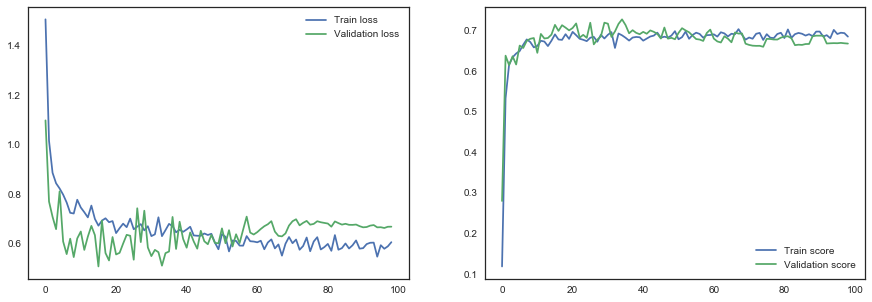

In [88]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

## finetune1 --fold 0 --branch with scse block unfreeze

In [97]:
def load_and_unfreeze(filename):
    co = {
        "lovasz_loss_elu": lovasz_loss_elu,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    for layer in model_pretrained.layers:
        layer.trainable = True
    
    c = SGD(lr=0.001, momentum=.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss_elu, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [93]:
model = load_and_unfreeze(model_finetune0_filepath)

In [95]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 101, 2)  0                                            
__________________________________________________________________________________________________
en1_a_conv (Conv2D)             (None, 101, 101, 16) 304         input[0][0]                      
__________________________________________________________________________________________________
en1_b_relu (Activation)         (None, 101, 101, 16) 0           en1_a_conv[0][0]                 
__________________________________________________________________________________________________
en1_b_bn (BatchNormalization)   (None, 101, 101, 16) 64          en1_b_relu[0][0]                 
__________________________________________________________________________________________________
en1_b_1_co

__________________________________________________________________________________________________
activation_231 (Activation)     (None, 156)          0           batch_normalization_102[0][0]    
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 8)            0           batch_normalization_101[0][0]    
__________________________________________________________________________________________________
dense_204 (Dense)               (None, 625)          98125       activation_231[0][0]             
__________________________________________________________________________________________________
dense_202 (Dense)               (None, 32)           288         activation_229[0][0]             
__________________________________________________________________________________________________
activation_232 (Activation)     (None, 625)          0           dense_204[0][0]                  
__________

__________________________________________________________________________________________________
en3_c_2_conv (Conv2D)           (None, 25, 25, 64)   36928       en3_c_1_relu[0][0]               
__________________________________________________________________________________________________
en3_c_2_bn (BatchNormalization) (None, 25, 25, 64)   256         en3_c_2_conv[0][0]               
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 25, 25, 1)    65          en3_c_2_bn[0][0]                 
__________________________________________________________________________________________________
global_max_pooling2d_54 (Global (None, 64)           0           en3_c_2_bn[0][0]                 
__________________________________________________________________________________________________
reshape_161 (Reshape)           (None, 625)          0           conv2d_54[0][0]                  
__________

en4_c_add (Add)                 (None, 12, 12, 128)  0           en4_b_add[0][0]                  
                                                                 add_56[0][0]                     
__________________________________________________________________________________________________
activation_255 (Activation)     (None, 12, 12, 128)  0           en4_c_add[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 6, 6, 128)    0           activation_255[0][0]             
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 6, 6, 128)    0           max_pooling2d_44[0][0]           
__________________________________________________________________________________________________
vm_a_conv (Conv2D)              (None, 6, 6, 256)    295168      dropout_31[0][0]                 
__________

__________________________________________________________________________________________________
de4_c_add (Add)                 (None, 12, 12, 128)  0           de4_b_add[0][0]                  
                                                                 add_58[0][0]                     
__________________________________________________________________________________________________
activation_265 (Activation)     (None, 12, 12, 128)  0           de4_c_add[0][0]                  
__________________________________________________________________________________________________
conv2d_transpose_42 (Conv2DTran (None, 25, 25, 64)   73792       activation_265[0][0]             
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 25, 25, 128)  0           conv2d_transpose_42[0][0]        
                                                                 activation_246[0][0]             
__________

batch_normalization_122 (BatchN (None, 156)          624         dense_243[0][0]                  
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 8)            32          dense_241[0][0]                  
__________________________________________________________________________________________________
activation_277 (Activation)     (None, 156)          0           batch_normalization_122[0][0]    
__________________________________________________________________________________________________
activation_275 (Activation)     (None, 8)            0           batch_normalization_121[0][0]    
__________________________________________________________________________________________________
dense_244 (Dense)               (None, 625)          98125       activation_277[0][0]             
__________________________________________________________________________________________________
dense_242 

__________________________________________________________________________________________________
de1_c_relu (Activation)         (None, 101, 101, 16) 0           de1_b_add[0][0]                  
__________________________________________________________________________________________________
de1_c_bn (BatchNormalization)   (None, 101, 101, 16) 64          de1_c_relu[0][0]                 
__________________________________________________________________________________________________
de1_c_1_conv (Conv2D)           (None, 101, 101, 16) 2320        de1_c_bn[0][0]                   
__________________________________________________________________________________________________
de1_c_1_bn (BatchNormalization) (None, 101, 101, 16) 64          de1_c_1_conv[0][0]               
__________________________________________________________________________________________________
de1_c_1_relu (Activation)       (None, 101, 101, 16) 0           de1_c_1_bn[0][0]                 
__________

In [94]:
for layer in model.layers[: 50]:
    print(layer.get_config())

{'batch_input_shape': (None, 101, 101, 2), 'dtype': 'float32', 'sparse': False, 'name': 'input'}
{'name': 'en1_a_conv', 'trainable': False, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'en1_b_relu', 'trainable': True, 'activation': 'relu'}
{'name': 'en1_b_bn', 'trainable': False, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Ze

In [98]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format("029", i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-block1-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0-block1-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    model_finetune1_filepath = "{}-model-resnet-finetune1-block1-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune1_filepath = "{}-log-resnet-finetune1-block1-fold-{}-run-{}.csv".format(exp_code, i, run)
    
    # model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i)
    # model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}.hdf5".format(exp_code, i)
    # log_finetune0_filepath = "{}-log-resnet-finetune0-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune0_filepath)
    print("model finetune0:", model_finetune1_filepath)
    print("log:", log_finetune1_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1) # reduce 2 16
    model_checkpoint = ModelCheckpoint(model_finetune1_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune1_filepath, separator=',', append=False)

    epochs = 1000
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_and_unfreeze(model_finetune0_filepath)
    print("build model.")
    
    def train():    
        return model_rebuild.fit_generator(generate_batch_data_random(X_train, Y_train, batch_size),
                                           validation_data=generate_batch_data(X_valid, Y_valid, 50), 
                                           epochs=5000,
                                           steps_per_epoch=100,
                                           callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger],
                                           validation_steps=17,
                                           verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 030-model-resnet-finetune0-block1-fold-0-run-1.hdf5
model finetune0: 030-model-resnet-finetune1-block1-fold-0-run-1.hdf5
log: 030-log-resnet-finetune1-block1-fold-0-run-1.csv
data.shape: (3196, 101, 101, 1) (3196, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
build model.
Epoch 1/5000

Epoch 00001: val_my_iou_metric improved from -inf to 0.77985, saving model to 030-model-resnet-finetune1-block1-fold-0-run-1.hdf5
Epoch 2/5000

Epoch 00002: val_my_iou_metric improved from 0.77985 to 0.78507, saving model to 030-model-resnet-finetune1-block1-fold-0-run-1.hdf5
Epoch 3/5000

Epoch 00003: val_my_iou_metric did not improve from 0.78507
Epoch 4/5000

Epoch 00004: val_my_iou_metric did not improve from 0.78507
Epoch 5/5000

Epoch 00005: val_my_iou_metric did not improve from 0.78507
Epoch 6/5000

Epoch 00006: val_my_iou_metric did not improve from 0.78507
Epoch 7/5000

Epoch 00007: val_my_iou_metric did not improve from 0.78507
Epoch 8/5000

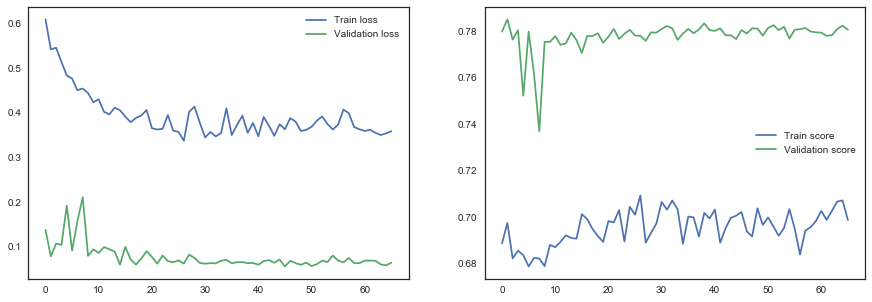

In [99]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()
plt.show()

## finetune0 --fold 0 --Fbranch scblock2

In [64]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-block2-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0-block2-fold-{}-run-{}.csv".format(exp_code, i, run)

    print("mode:", model_filepath)
    print("model finetune0:", model_finetune0_filepath)
    print("log:", log_finetune0_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune0_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
    model_logger = CSVLogger(log_finetune0_filepath, separator=',', append=False)

    epochs = 1000
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_model_add_scblock2(model_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time history = train()
    break

fold: 0
run: 1
index.shape: (3196,) (804,)
mode: 029-model-resnet-fold-0-run-1.hdf5
model finetune0: 029-model-resnet-finetune0-block2-fold-0-run-1.hdf5
log: 029-log-resnet-finetune0-block2-fold-0-run-1.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
en1_a_conv
en1_b_bn
en1_b_1_conv
en1_b_1_bn
en1_b_2_conv
en1_b_2_bn
en1_c_bn
en1_c_1_conv
en1_c_1_bn
en1_c_2_conv
en1_c_2_bn
en2_a_conv
en2_b_bn
en2_b_1_conv
en2_b_1_bn
en2_b_2_conv
en2_b_2_bn
en2_c_bn
en2_c_1_conv
en2_c_1_bn
en2_c_2_conv
en2_c_2_bn
en3_a_conv
en3_b_bn
en3_b_1_conv
en3_b_1_bn
en3_b_2_conv
en3_b_2_bn
en3_c_bn
en3_c_1_conv
en3_c_1_bn
en3_c_2_conv
en3_c_2_bn
en4_a_conv
en4_b_bn
en4_b_1_conv
en4_b_1_bn
en4_b_2_conv
en4_b_2_bn
en4_c_bn
en4_c_1_conv
en4_c_1_bn
en4_c_2_conv
en4_c_2_bn
vm_a_conv
vm_b_bn
vm_b_1_conv
vm_b_1_bn
vm_b_2_conv
vm_b_2_bn
vm_c_bn
vm_c_1_conv
vm_c_1_bn
vm_c_2_conv
vm_c_2_bn
de4_a_conv
de4_b_bn
de4_b_1_conv
de4_b_1_bn
de4_b_2_conv
de4_b_2_bn
de4_c_bn
de4_c_1_conv

KeyboardInterrupt: 

## finetune3 --fold0

In [76]:
def load_finetune2_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.005, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [77]:
for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    log_finetune3_filepath = "{}-log-resnet-finetune3-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune1_filepath)
    print("model finetune0:", model_finetune3_filepath)
    print("log:", log_finetune3_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=32, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune3_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune3_filepath, separator=',', append=False)

    epochs = 500 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    model_rebuild = load_finetune2_model(model_finetune2_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune1-fold-0.hdf5
model finetune0: 025-model-resnet-finetune3-fold-0.hdf5
log: 025-log-resnet-finetune3-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/500

Epoch 00001: val_my_iou_metric improved from -inf to 0.78445, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 2/500

Epoch 00002: val_my_iou_metric improved from 0.78445 to 0.78607, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 3/500

Epoch 00003: val_my_iou_metric did not improve from 0.78607
Epoch 4/500

Epoch 00004: val_my_iou_metric improved from 0.78607 to 0.78769, saving model to 025-model-resnet-finetune3-fold-0.hdf5
Epoch 5/500

Epoch 00005: val_my_iou_metric did not improve from 0.78769
Epoch 6/500

Epoch 00006: val_my_iou_metric did not improve from 0.78769
Epoch 7/500

Epoch 00007: val_my_iou_metric did no

## finetune4 --fold 0

In [20]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [25]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    log_finetune4_filepath = "{}-log-resnet-finetune4-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune3_filepath)
    print("model finetune4:", model_finetune4_filepath)
    print("log:", log_finetune4_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=60, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune4_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune4_filepath, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_finetune4_filepath) # continue
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune3-fold-0.hdf5
model finetune4: 025-model-resnet-finetune4-fold-0.hdf5
log: 025-log-resnet-finetune4-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79689, saving model to 025-model-resnet-finetune4-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric did not improve from 0.79689
Epoch 3/1000

Epoch 00003: val_my_iou_metric improved from 0.79689 to 0.79813, saving model to 025-model-resnet-finetune4-fold-0.hdf5
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79813
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.79813
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.79813
Epoch 7/1000

Epoch 00007: val_my_iou_metric did not improve from 0.79813
Epoch 8/1000

Epoch 00008: val

## finetune5 --fold 0

In [30]:
def load_finetune4_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    # c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    c = Adadelta()
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [28]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    log_finetune5_filepath = "{}-log-resnet-finetune5-fold-{}.csv".format(exp_code, i)

    print("mode:", model_finetune4_filepath)
    print("model finetune4:", model_finetune5_filepath)
    print("log:", log_finetune5_filepath)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_finetune5_filepath, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_finetune5_filepath, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_finetune4_filepath) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode: 025-model-resnet-finetune4-fold-0.hdf5
model finetune4: 025-model-resnet-finetune5-fold-0.hdf5
log: 025-log-resnet-finetune5-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79391, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.79391 to 0.79602, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.79602
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79602
Epoch 5/1000

Epoch 00005: val_my_iou_metric improved from 0.79602 to 0.79751, saving model to 025-model-resnet-finetune5-fold-0.hdf5
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.79751
Epoch 7/1000

Epoch 00007: val_my_iou_metric

## finetune6 --fold 0

In [29]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    c = SGD(lr=0.002, momentum=0.9, decay=1e-6)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric])
    return model_pretrained

In [31]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 5
    cur_round = 6
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune4_model(model_filepath_prev) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune5-fold-0.hdf5
model next: 025-model-resnet-finetune6-fold-0.hdf5
log: 025-log-resnet-finetune6-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.78669, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.78669 to 0.79266, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.79266
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.79266
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.79266
Epoch 6/1000

Epoch 00006: val_my_iou_metric improved from 0.79266 to 0.80236, saving model to 025-model-resnet-finetune6-fold-0.hdf5
Epoch 7/1000

Epoch 00007: val_my_iou_

## finetune7 --fold 0

In [32]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 6
    cur_round = 7
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=50, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.75, patience=15, min_lr=0.00001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    model_rebuild = load_finetune3_model(model_filepath_prev) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, model_logger], 
                                 verbose=200)
    
    %time train()
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune6-fold-0.hdf5
model next: 025-model-resnet-finetune7-fold-0.hdf5
log: 025-log-resnet-finetune7-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.79017, saving model to 025-model-resnet-finetune7-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.79017 to 0.80100, saving model to 025-model-resnet-finetune7-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric did not improve from 0.80100
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.80100
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.80100
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.80100
Epoch 7/1000

Epoch 00007: val_my_iou_metric did not improve from 0.80100
Epoch 8/1000

Epoch 0000

## finetune8 --fold 0

In [47]:
def load_finetune3_model(filename):
    co = {
        "lovasz_loss": lovasz_loss,
        "my_iou_metric": my_iou_metric
    }
    model_pretrained = load_model(filename, custom_objects=co)
    
    # model_rebuild = build_model_complex(101)
    # copy_weights(model_rebuild, model_pretrained)

    # c = SGD(lr=0.001, momentum=0.9, decay=1e-6)
    c = Adam(lr=0.001)
    # c = RMSprop(lr=0.001)
    model_pretrained.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric]) ## new loss
    return model_pretrained

In [50]:
run = 0

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    # break
    print("fold:", i)
    print("run:", run)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    
    prev_round = 7
    cur_round = 8
    
    model_filepath = "{}-model-resnet-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    model_finetune0_filepath = "{}-model-resnet-finetune0-fold-{}-run-{}.hdf5".format(exp_code, i, run)
    log_finetune0_filepath = "{}-log-resnet-finetune0--fold-{}-run-{}.csv".format(exp_code, i, run)

    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    model_finetune1_filepath = "{}-model-resnet-finetune1-fold-{}.hdf5".format(exp_code, i)
    model_finetune2_filepath = "{}-model-resnet-finetune2-fold-{}.hdf5".format(exp_code, i)
    model_finetune3_filepath = "{}-model-resnet-finetune3-fold-{}.hdf5".format(exp_code, i)
    model_finetune4_filepath = "{}-model-resnet-finetune4-fold-{}.hdf5".format(exp_code, i)
    model_finetune5_filepath = "{}-model-resnet-finetune5-fold-{}.hdf5".format(exp_code, i)
    
    model_filepath_prev = "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, prev_round, i)
    model_filepath_cur =  "{}-model-resnet-finetune{}-fold-{}.hdf5".format(exp_code, cur_round, i)
    log_filepath_cur = "{}-log-resnet-finetune{}-fold-{}.csv".format(exp_code, cur_round, i)

    print("mode pretrained:", model_filepath_prev)
    print("model next:", model_filepath_cur)
    print("log:", log_filepath_cur)
    metric_name = "val_my_iou_metric"

    early_stopping = EarlyStopping(monitor=metric_name, mode = 'max',patience=64, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath_cur, monitor=metric_name, mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1) # factor = 0.5
    model_logger = CSVLogger(log_filepath_cur, separator=',', append=False)

    epochs = 1000 # 500
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    X_train = np.array([append_depth_channel(x) for x in X_train])
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    X_valid = np.array([append_depth_channel(x) for x in X_valid])

    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # model_rebuild = load_finetune3_model(model_finetune3_filepath)
    # model_rebuild = load_finetune3_model(model_filepath_prev) # 
    model_rebuild = load_finetune3_model(model_filepath_cur) # 
    # model_rebuild = load_finetune3_model(model_finetune5_filepath)
    print("build model.")
    
    def train():
        return model_rebuild.fit(X_train, Y_train,
                                 validation_data=[X_valid, Y_valid], 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                                 verbose=200)
    
    %time train() 
    break

fold: 0
run: 0
index.shape: (3196,) (804,)
mode pretrained: 025-model-resnet-finetune7-fold-0.hdf5
model next: 025-model-resnet-finetune8-fold-0.hdf5
log: 025-log-resnet-finetune8-fold-0.csv
data.shape: (6392, 101, 101, 2) (6392, 101, 101, 1) (804, 101, 101, 2) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/1000

Epoch 00001: val_my_iou_metric improved from -inf to 0.75609, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 2/1000

Epoch 00002: val_my_iou_metric improved from 0.75609 to 0.77749, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 3/1000

Epoch 00003: val_my_iou_metric improved from 0.77749 to 0.78582, saving model to 025-model-resnet-finetune8-fold-0.hdf5
Epoch 4/1000

Epoch 00004: val_my_iou_metric did not improve from 0.78582
Epoch 5/1000

Epoch 00005: val_my_iou_metric did not improve from 0.78582
Epoch 6/1000

Epoch 00006: val_my_iou_metric did not improve from 0.78582
Epoch 7/1000

Epoch 00007: val_my_iou_